## Visualising Hyperparameter Tuning for Load Forecasts

In [1]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import comma_format, percent_format, currency_format
from datetime import datetime, timedelta, date
from tqdm.notebook import tqdm
from skimpy import clean_columns
from IPython.display import clear_output, display

pd.set_option("display.max.columns", 50)

%load_ext blackcellmagic

TBD:
- Evaluate all four models on the test period
    - Meta
    - Three base models
- Evaluation Metrics
- Visualisations (By quarter hour, hour in day as well as hour in week and day in week)

### Reading in the Test Period Predictions

In [2]:
preds_meta = pd.read_csv("Predictions/holdout_predictions_final.csv", parse_dates=["datetime"])
preds_pytorch = pd.read_csv("Predictions/test_pytorch_newsplits_nopv.csv", parse_dates=["datetime"])
preds_xgboost = pd.read_csv("Predictions/test_xgboost_newsplits_nopv.csv", parse_dates=["datetime"])
preds_randomforest = pd.read_csv("Predictions/test_randomforest_newsplits_nopv.csv", parse_dates=["datetime"])
preds_lgbm = pd.read_csv("Predictions/test_lgbm_newsplits_nopv.csv", parse_dates=["datetime"])

In [3]:
predictions = (
    preds_meta.merge(preds_pytorch, how="left")
    .merge(preds_xgboost, how="left")
    .merge(preds_randomforest, how="left")
    .merge(preds_lgbm, how="left")
)

### Evaluation Metrics

In [4]:
def format_float_with_4_decimals(x):
    return "{:.4f}".format(x)

(
    predictions.drop("datetime", axis=1)
    .melt(id_vars="actuals", var_name="model", value_name="pred")
    .groupby("model")
    .apply(
        lambda x: pd.Series(
            {
                "R2": r2_score(x["actuals"], x["pred"]),
                "MAPE": mean_absolute_percentage_error(x["actuals"], x["pred"]),
                "MSE": mean_squared_error(x["actuals"], x["pred"]),
                "RMSE": mean_squared_error(x["actuals"], x["pred"], squared=False),
            }
        )
    )
    .reset_index()
    .melt(id_vars="model", var_name="metric_name")
    .pivot(columns="model", index="metric_name", values="value")
    .reset_index()
    .rename_axis(None, axis=1)
    .style.format(
        {
            "y_pred_val": format_float_with_4_decimals,
        }
    )
)

### Balancing Energy

In [5]:
bal_energy = pd.read_excel("../Balancing Energy.xlsx").pipe(clean_columns)
bal_energy

datetime  archiv_aln_1  archiv_bob  archiv_prognose_export  \
0    2023-04-01 00:00:00    568637.007  545749.667              553667.884   
1    2023-04-01 00:15:00    572520.050  549730.183              555144.306   
2    2023-04-01 00:30:00    568726.865  545774.446              548565.525   
3    2023-04-01 00:45:00    557697.390  535324.173              533741.925   
4    2023-04-01 01:00:00    587892.576  565078.799              564124.664   
...                  ...           ...         ...                     ...   
8731 2023-06-30 22:45:00    475416.985  469509.541              454173.631   
8732 2023-06-30 23:00:00    496362.398  489277.025              473933.202   
8733 2023-06-30 23:15:00    483467.722  476094.343              461444.419   
8734 2023-06-30 23:30:00    496921.716  490454.419              474571.881   
8735 2023-06-30 23:45:00    481500.685  474634.332              459228.690   

        spot  long_eur_mwh  short_eur_mwh  
0      96.70       107.958        199.842  
1      96.70       143.014        203.386  
2      96.70       103.226        191.274  
3      96.70        99.793        128.107  
4      98.34       125.120        225.980  
...      ...           ...            ...  
8731  112.19        66.782        138.218  
8732  108.08       101.743        123.457  
8733  108.08       102.591        126.209  
8734  108.08       100.856        108.944  
8735  108.08        58.813         98.187  

[8736 rows x 7 columns]

In [6]:
opp_costs = (
    predictions.merge(bal_energy, how="left", on="datetime")
    .melt(
        id_vars=["datetime", "actuals", "spot", "long_eur_mwh", "short_eur_mwh"],
        var_name="model_name",
        value_name="prediction",
    )
    .assign(
        delta=lambda x: x["prediction"] - x["actuals"],
        opp_cost=lambda x: np.where(
            x["delta"] > 0,
            x["long_eur_mwh"] - x["spot"],
            x["short_eur_mwh"] - x["spot"],
        )
        * x["delta"]
        / 4000,
        month=lambda x: x["datetime"].dt.month.astype(str),
    )
)

opp_costs

datetime     actuals    spot  long_eur_mwh  short_eur_mwh  \
0     2023-04-01 00:00:00  554900.992   96.70       107.958        199.842   
1     2023-04-01 00:15:00  556882.092   96.70       143.014        203.386   
2     2023-04-01 00:30:00  550242.504   96.70       103.226        191.274   
3     2023-04-01 00:45:00  543646.392   96.70        99.793        128.107   
4     2023-04-01 01:00:00  573875.112   98.34       125.120        225.980   
...                   ...         ...     ...           ...            ...   
69883 2023-06-30 22:45:00  455014.940  112.19        66.782        138.218   
69884 2023-06-30 23:00:00  475961.968  108.08       101.743        123.457   
69885 2023-06-30 23:15:00  466107.956  108.08       102.591        126.209   
69886 2023-06-30 23:30:00  475540.956  108.08       100.856        108.944   
69887 2023-06-30 23:45:00  462110.848  108.08        58.813         98.187   

                   model_name     prediction         delta    opp_cost month  
0            meta_predictions  538991.872514 -15909.119486 -410.224601     4  
1            meta_predictions  538135.520774 -18746.571226 -499.999174     4  
2            meta_predictions  536757.058173 -13485.445827 -318.843138     4  
3            meta_predictions  534849.203804  -8797.188196  -69.073322     4  
4            meta_predictions  545020.630916 -28854.481084 -920.746491     4  
...                       ...            ...           ...         ...   ...  
69883  archiv_prognose_export  454173.631000   -841.309000   -5.474398     6  
69884  archiv_prognose_export  473933.202000  -2028.766000   -7.799084     6  
69885  archiv_prognose_export  461444.419000  -4663.537000  -21.136316     6  
69886  archiv_prognose_export  474571.881000   -969.075000   -0.209320     6  
69887  archiv_prognose_export  459228.690000  -2882.158000    7.128297     6  

[69888 rows x 10 columns]

In [7]:
def format_float_without_decimals(x):
    return "{:,.0f}".format(x)


(
    opp_costs
    .groupby(["model_name", "month"])
    .apply(lambda x: pd.Series({"opp_cost": np.sum(x["opp_cost"])}))
    .reset_index()
    .pivot(columns="month", values="opp_cost", index="model_name")
    .reset_index()
    .rename_axis(None, axis=1)
    .assign(total_cost=lambda x: x[["4", "5", "6"]].sum(axis=1).pipe(np.abs))
    .sort_values("total_cost")
    .style.bar(subset=["total_cost"], color="green")
    .format(
        {
            "4": format_float_without_decimals,
            "5": format_float_without_decimals,
            "6": format_float_without_decimals,
            "total_cost": format_float_without_decimals,
        }
    )
)

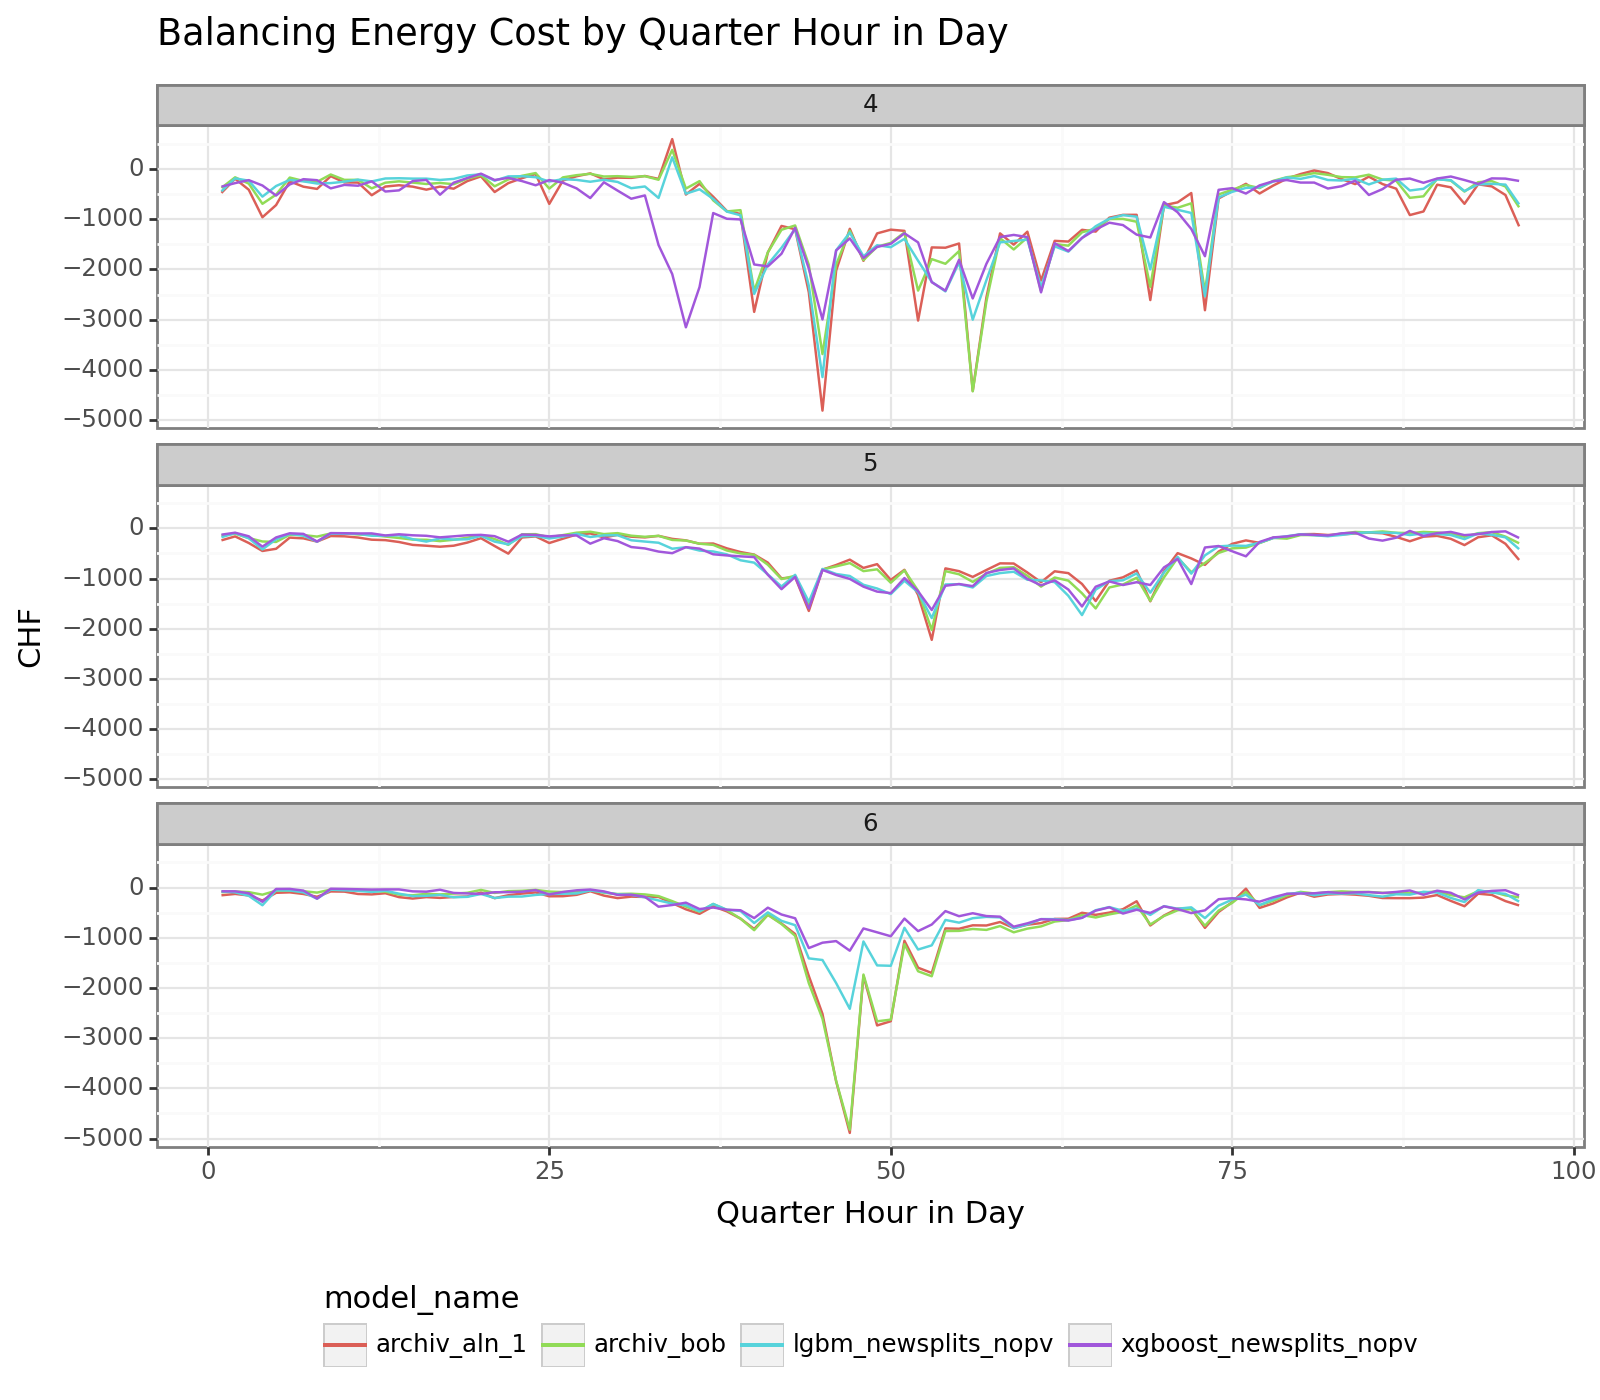

<Figure Size: (800 x 700)>

In [8]:
(
    ggplot(
        data=(
            opp_costs.query(
                'model_name in ["xgboost_newsplits_nopv", "lgbm_newsplits_nopv", "archiv_bob", "archiv_aln_1",]'
            )
            .assign(
                quarter_hour=lambda x: (x.datetime.dt.hour * 60 + x.datetime.dt.minute)
                // 15
                + 1
            )
            .drop("datetime", axis=1)
            .groupby(["model_name", "quarter_hour", "month"])
            .apply(
                lambda x: pd.Series(
                    {"opp_cost": np.mean(x["opp_cost"]), "delta": np.mean(x["delta"])}
                )
            )
            .reset_index()
        ),
        mapping=aes(x="quarter_hour", y="opp_cost", colour="model_name"),
    )
    + geom_line()
    + labs(
        title="Balancing Energy Cost by Quarter Hour in Day",
        y="CHF",
        x="Quarter Hour in Day",
    )
    + facet_wrap("~ month", ncol=1)
    + theme_bw()
    + theme(figure_size=[8, 7], legend_position="bottom")
)

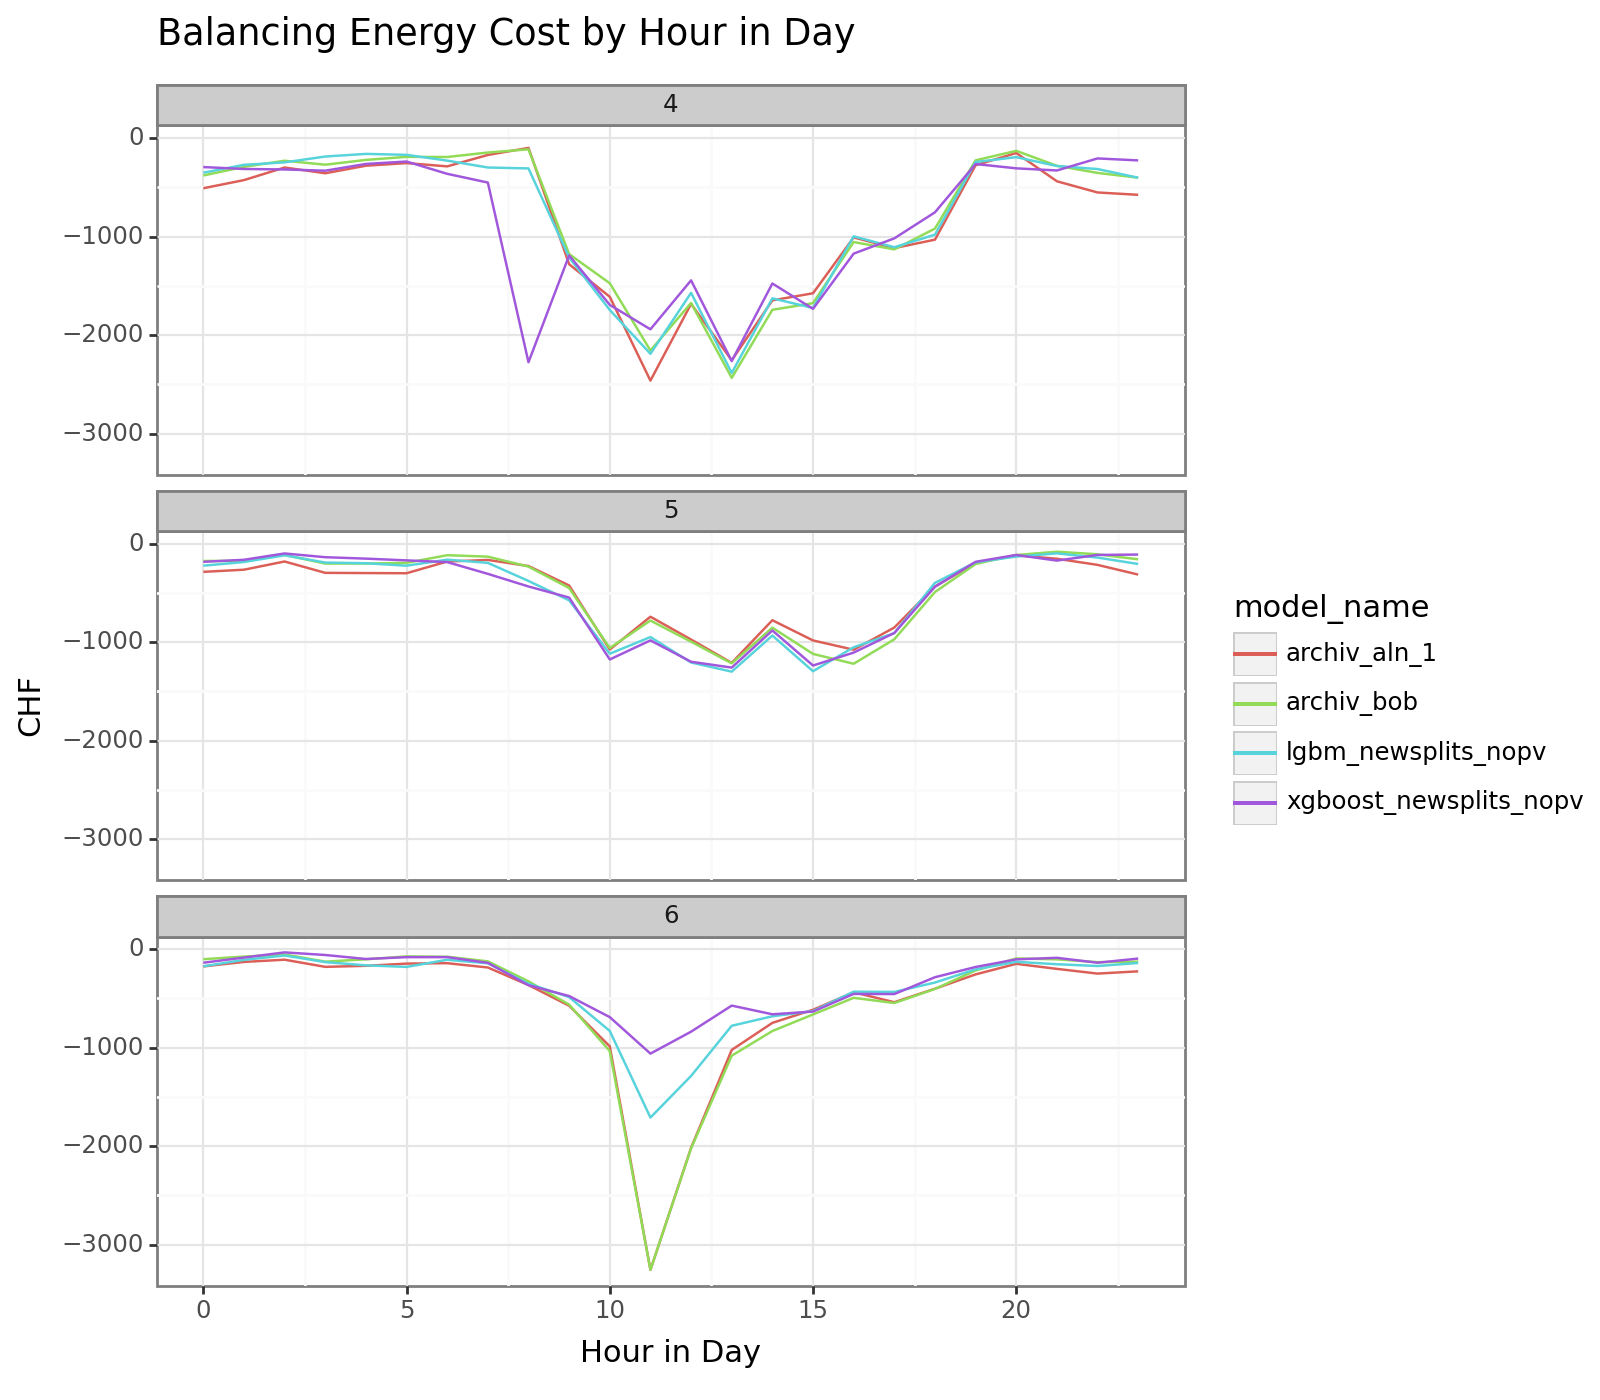

<Figure Size: (800 x 700)>

In [9]:
(
    ggplot(
        data=(
            opp_costs.query(
                'model_name in ["xgboost_newsplits_nopv", "lgbm_newsplits_nopv", "archiv_bob", "archiv_aln_1",]'
            )
            .assign(hour=lambda x: (x.datetime.dt.hour))
            .drop("datetime", axis=1)
            .groupby(["model_name", "hour", "month"])
            .apply(
                lambda x: pd.Series(
                    {"opp_cost": np.mean(x["opp_cost"]), "delta": np.mean(x["delta"])}
                )
            )
            .reset_index()
        ),
        mapping=aes(x="hour", y="opp_cost", colour="model_name"),
    )
    + geom_line()
    + labs(
        title="Balancing Energy Cost by Hour in Day",
        y="CHF",
        x="Hour in Day",
    )
    + facet_wrap("~ month", ncol=1)
    + theme_bw()
    + theme(figure_size=[8, 7], legend_position="right")
)

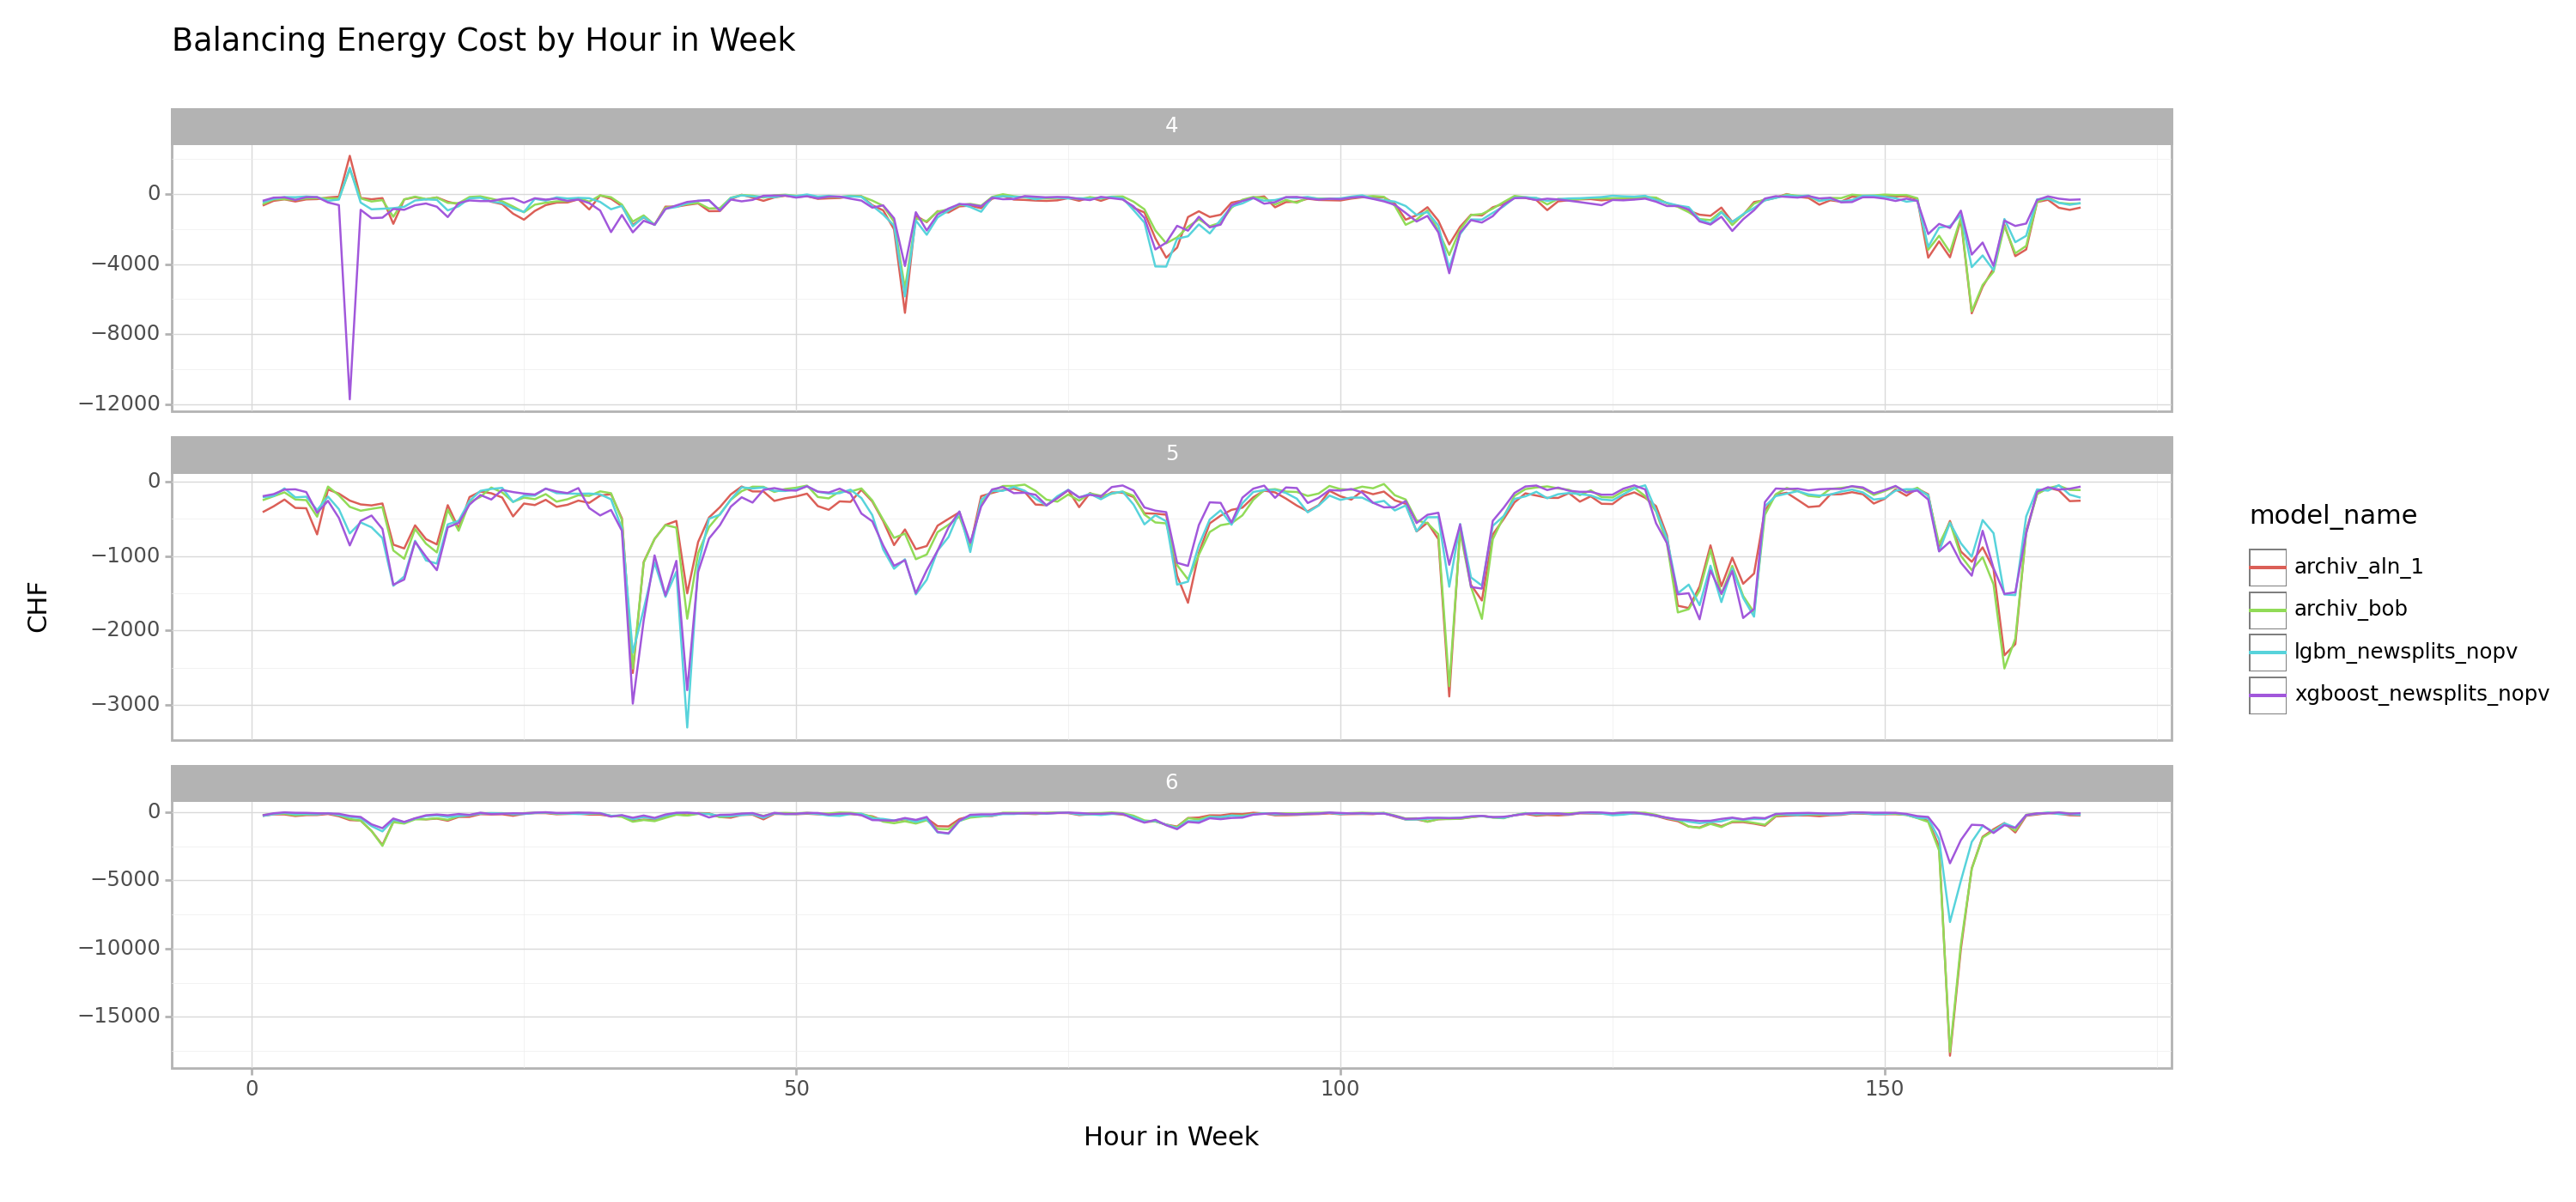

<Figure Size: (1500 x 700)>

In [10]:
(
    ggplot(
        data=(
            opp_costs.query(
                'model_name in ["xgboost_newsplits_nopv", "lgbm_newsplits_nopv", "archiv_bob", "archiv_aln_1",]'
            )
            .assign(week_hour=lambda x: x.datetime.dt.dayofweek * 24 + (x.datetime.dt.hour + 1))
            .drop("datetime", axis=1)
            .groupby(["model_name", "week_hour", "month"])
            .apply(
                lambda x: pd.Series(
                    {"opp_cost": np.mean(x["opp_cost"]), "delta": np.mean(x["delta"])}
                )
            )
            .reset_index()
        ),
        mapping=aes(x="week_hour", y="opp_cost", colour="model_name"),
    )
    + geom_line()
    + labs(
        title="Balancing Energy Cost by Hour in Week",
        y="CHF",
        x="Hour in Week",
    )
    + facet_wrap("~ month", ncol=1, scales="free_y")
    + theme_light()
    + theme(figure_size=[15, 7], legend_position="right")
)

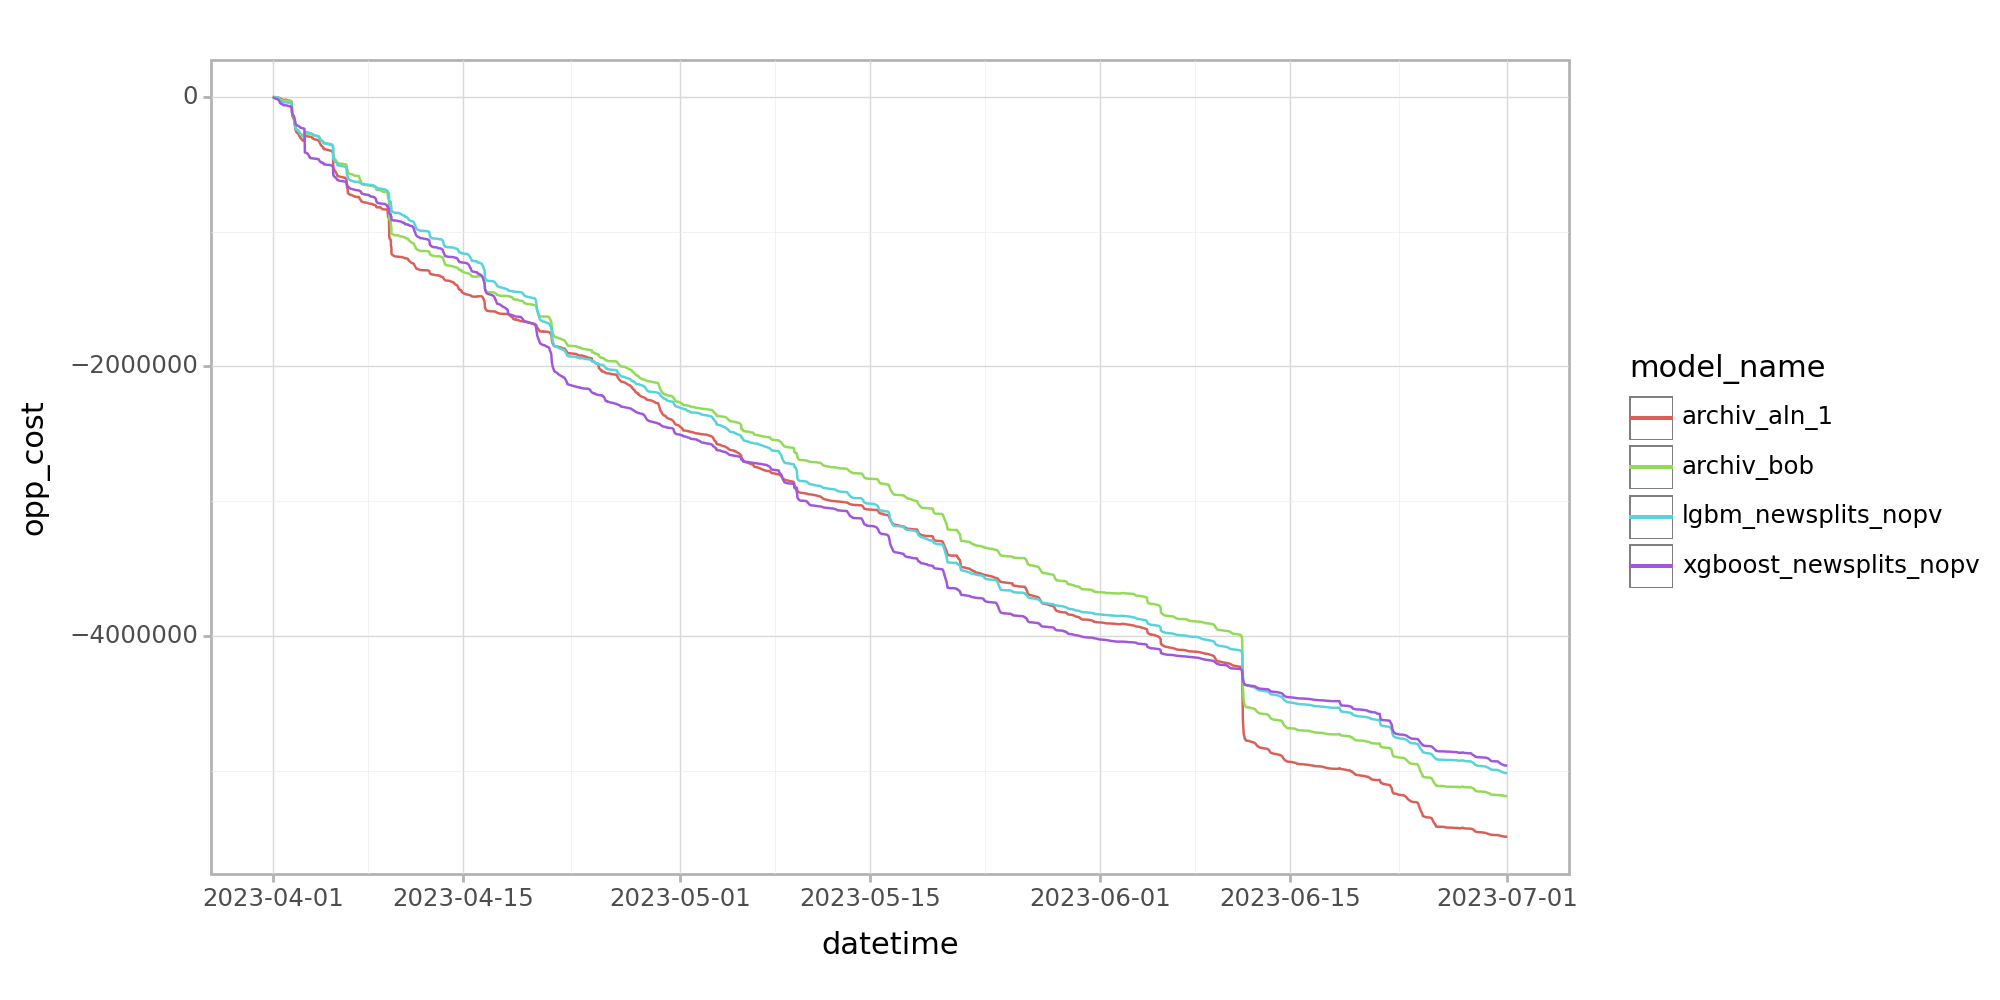

<Figure Size: (1000 x 500)>

In [11]:
(
    ggplot(
        data=(
            opp_costs.query(
                'model_name in ["xgboost_newsplits_nopv", "lgbm_newsplits_nopv", "archiv_bob", "archiv_aln_1",]'
            )
            .sort_values(["model_name", "datetime"])
            .reset_index(drop=True)
            .assign(
                opp_cost=lambda x: x.groupby("model_name")["opp_cost"].transform(
                    "cumsum"
                )
            )
        ),
        mapping=aes(x="datetime", y="opp_cost", colour="model_name"),
    )
    + geom_line()
    + theme_light()
    + theme(figure_size=[10, 5])
)

In [29]:
(opp_costs.filter(["datetime", "actuals", "prediction", "model_name"]).melt(
            id_vars=["datetime", "model_name"], var_name="type"
        ).query(
                'model_name in ["xgboost_newsplits_nopv", "lgbm_newsplits_nopv", "archiv_bob", "archiv_aln_1",]'
            ))

datetime              model_name        type       value
17472  2023-04-01 00:00:00  xgboost_newsplits_nopv     actuals  554900.992
17473  2023-04-01 00:15:00  xgboost_newsplits_nopv     actuals  556882.092
17474  2023-04-01 00:30:00  xgboost_newsplits_nopv     actuals  550242.504
17475  2023-04-01 00:45:00  xgboost_newsplits_nopv     actuals  543646.392
17476  2023-04-01 01:00:00  xgboost_newsplits_nopv     actuals  573875.112
...                    ...                     ...         ...         ...
131035 2023-06-30 22:45:00              archiv_bob  prediction  469509.541
131036 2023-06-30 23:00:00              archiv_bob  prediction  489277.025
131037 2023-06-30 23:15:00              archiv_bob  prediction  476094.343
131038 2023-06-30 23:30:00              archiv_bob  prediction  490454.419
131039 2023-06-30 23:45:00              archiv_bob  prediction  474634.332

[69888 rows x 4 columns]

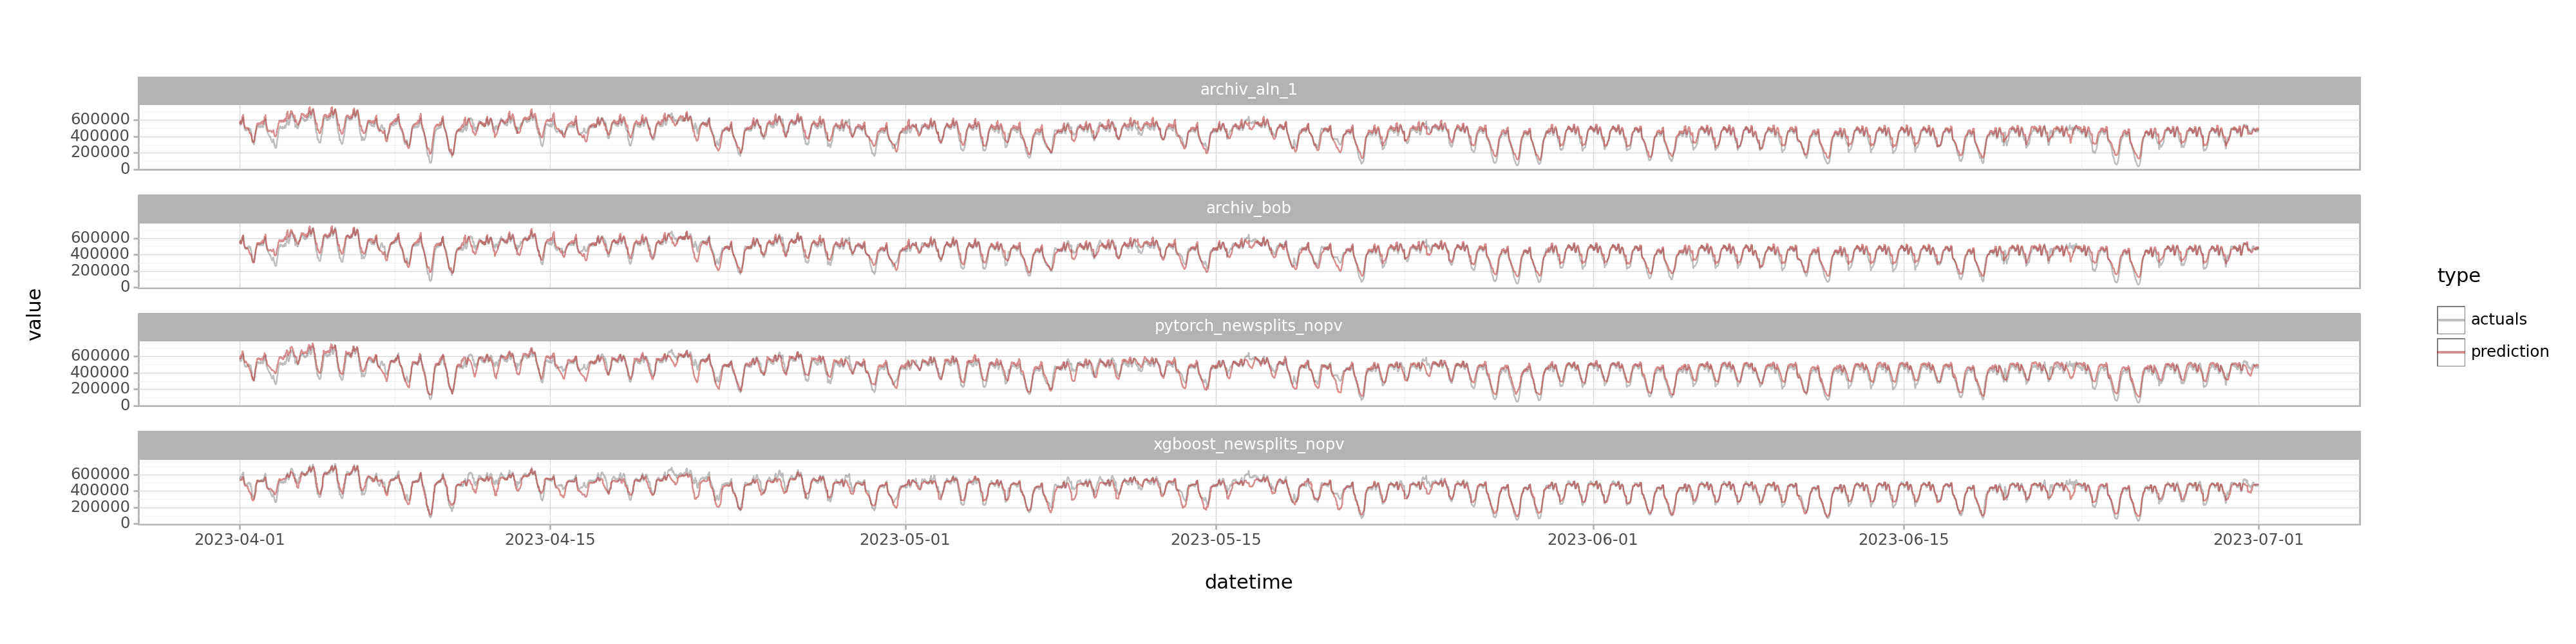

<Figure Size: (2000 x 500)>

In [45]:
(
    ggplot(
        data=(opp_costs.filter(["datetime", "actuals", "prediction", "model_name"]).melt(
            id_vars=["datetime", "model_name"], var_name="type"
        ).query(
                'model_name in ["xgboost_newsplits_nopv", "pytorch_newsplits_nopv", "archiv_bob", "archiv_aln_1",]'
            )),
        mapping=aes(x="datetime", y="value", colour="type"),
    )
    + geom_line(alpha=0.5)
    + facet_wrap("~ model_name", ncol=1)
    + scale_colour_manual(values=["grey", "firebrick"])
    + theme_light()
    + theme(figure_size=[20, 5])
)

TBD: Analyse to see if patterns are visible compared to Belvis  
TBD: Analyse if model is still better if excluding the one big day  

### PV Shift

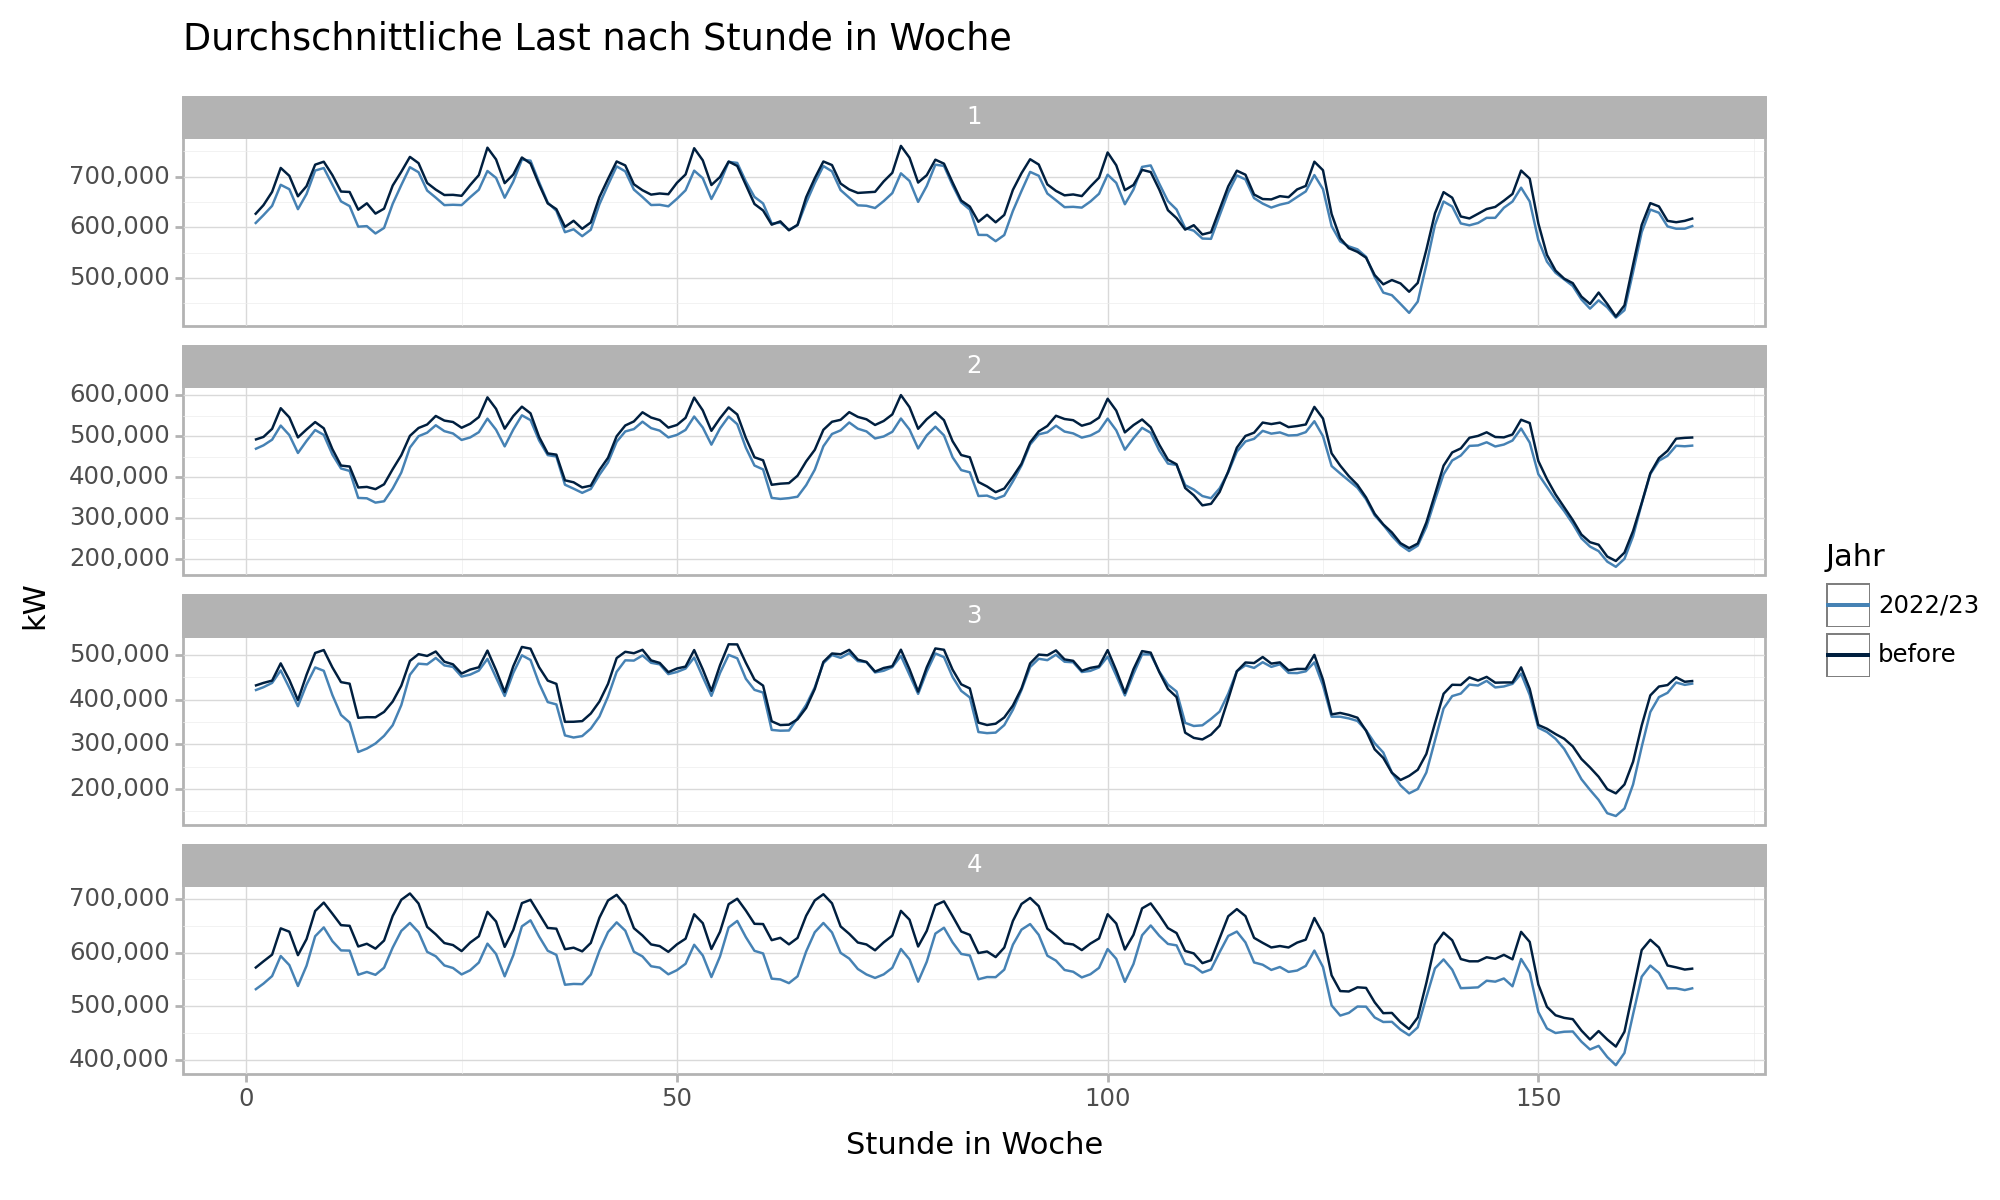

<Figure Size: (1000 x 600)>

In [192]:
(
    ggplot(
        data=(
            pd.concat(
                [
                    pd.read_pickle("Preprocessed Data/df_base_preprocessed.pickle"),
                    pd.read_pickle(
                        "Preprocessed Data/df_base_preprocessed_holdout.pickle"
                    ),
                ],
                axis=0,
            )
            .reset_index(drop=True)
            .filter(["datetime", "kW"])
            .assign(
                quarter=lambda x: x.datetime.dt.quarter.astype(str),
                year=lambda x: np.where(np.isin(x.datetime.dt.year, [2022, 2023]), "2022/23", "before"),
                hour=lambda x: x.datetime.dt.dayofweek * 24 + (x.datetime.dt.hour + 1),
            )
            .groupby(["year", "quarter", "hour"])
            .apply(
                lambda x: pd.Series(
                    {
                        "lower": x.kW.quantile(0.05),
                        "middle": x.kW.mean(),
                        "higher": x.kW.quantile(0.95),
                    }
                )
            )
            .reset_index()
        ),
        mapping=aes(x="hour"),
    )
    + labs(title="Last nach Stunde in Woche", y="kW", x="Stunde in Woche")
    + geom_line(mapping=aes(y="middle", colour="year", group="year"))
    # + geom_ribbon(mapping=aes(ymin="lower", ymax="higher"))
    + labs(title="Durchschnittliche Last nach Stunde in Woche", colour="Jahr")
    + facet_wrap("~ quarter", ncol=1, scales="free_y")
    + scale_y_continuous(labels=comma_format())
    + scale_colour_manual(
        values=[
            "#4682b4",  # Medium Blue
            "#001f3f",  # Very Dark Blue
        ]
    )
    + theme_light()
    + theme(figure_size=[10, 6])
)

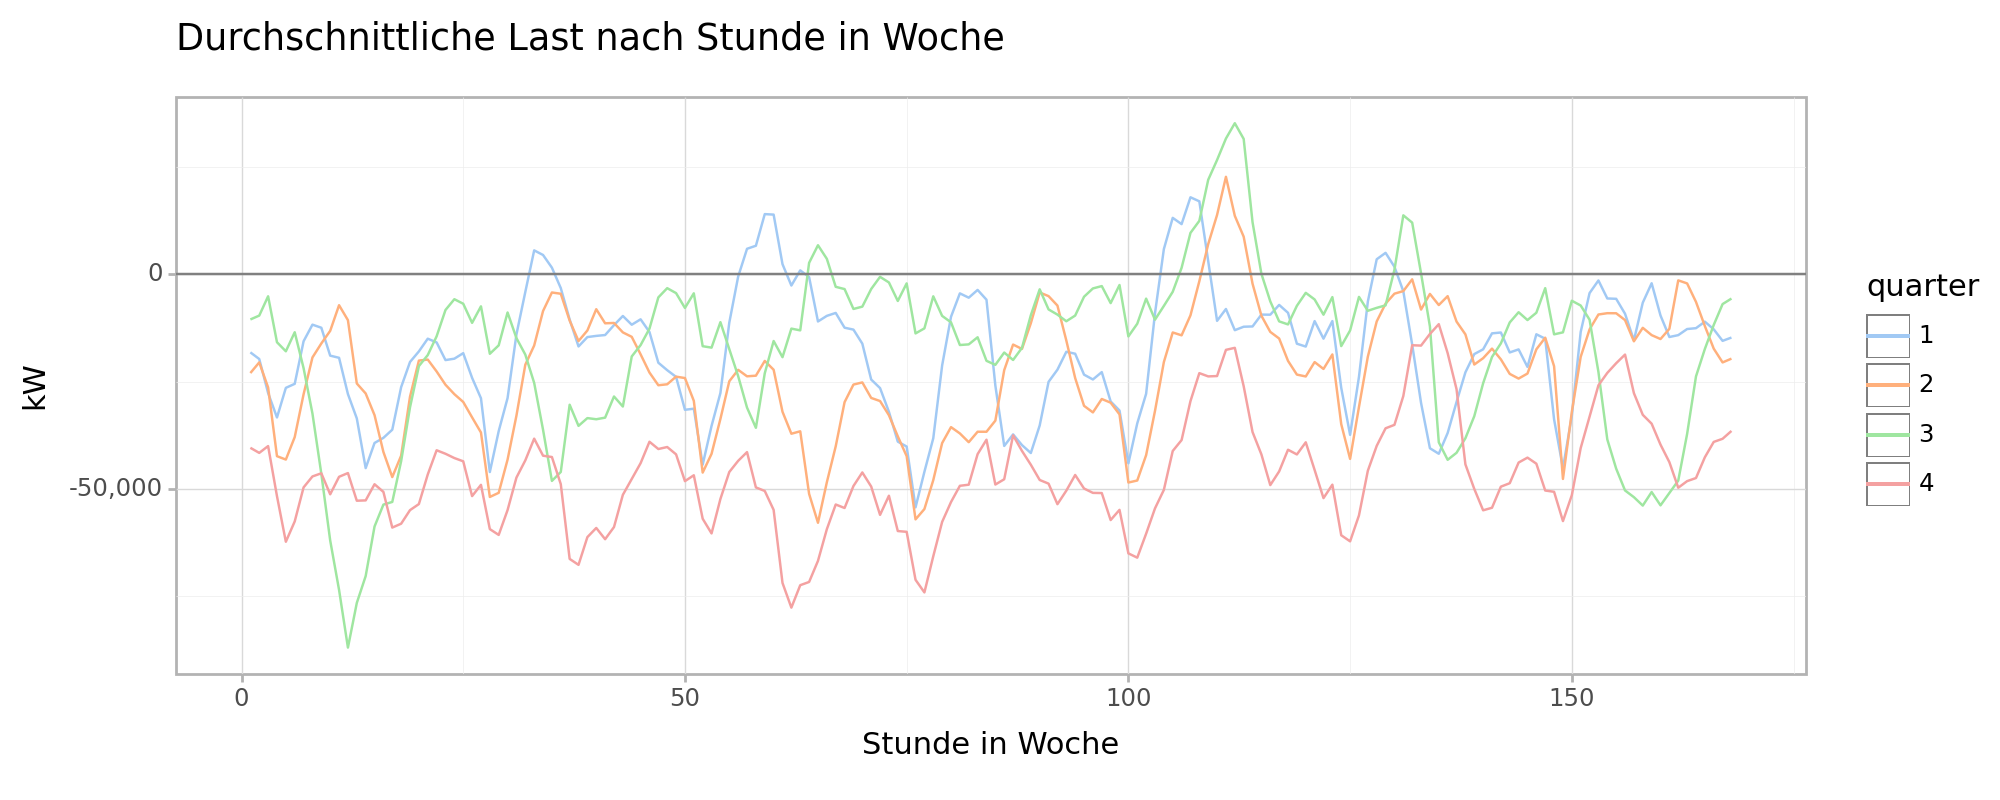

<Figure Size: (1000 x 400)>

In [193]:
(
    ggplot(
        data=(
            pd.concat(
                [
                    pd.read_pickle("Preprocessed Data/df_base_preprocessed.pickle"),
                    pd.read_pickle(
                        "Preprocessed Data/df_base_preprocessed_holdout.pickle"
                    ),
                ],
                axis=0,
            )
            .reset_index(drop=True)
            .filter(["datetime", "kW"])
            .assign(
                quarter=lambda x: x.datetime.dt.quarter.astype(str),
                year=lambda x: np.where(
                    np.isin(x.datetime.dt.year, [2022, 2023]), "2022/23", "before"
                ),
                hour=lambda x: x.datetime.dt.dayofweek * 24 + (x.datetime.dt.hour + 1),
            )
            .groupby(["year", "quarter", "hour"])
            .apply(
                lambda x: pd.Series(
                    {
                        "middle": x.kW.mean(),
                    }
                )
            )
            .reset_index()
            .pivot(index=["quarter", "hour"], columns="year", values="middle")
            .reset_index()
            .rename_axis(None, axis=1)
            .assign(delta=lambda x: x["2022/23"] - x["before"])
        ),
        mapping=aes(x="hour"),
    )
    + labs(title="Last nach Stunde in Woche", y="kW", x="Stunde in Woche")
    + geom_line(mapping=aes(y="delta", colour="quarter"))
    + geom_hline(yintercept=0, colour="grey")
    + labs(title="Durchschnittliche Last nach Stunde in Woche")
    + scale_y_continuous(labels=comma_format())
    + scale_colour_manual(
        values=[
            "#a1c9f4",  # Pastel Blue
            "#ffb07c",  # Pastel Orange
            "#9fe6a0",  # Pastel Green
            "#f4a1a1",  # Pastel Red
        ]
    )
    + theme_light()
    + theme(figure_size=[10, 4])
)

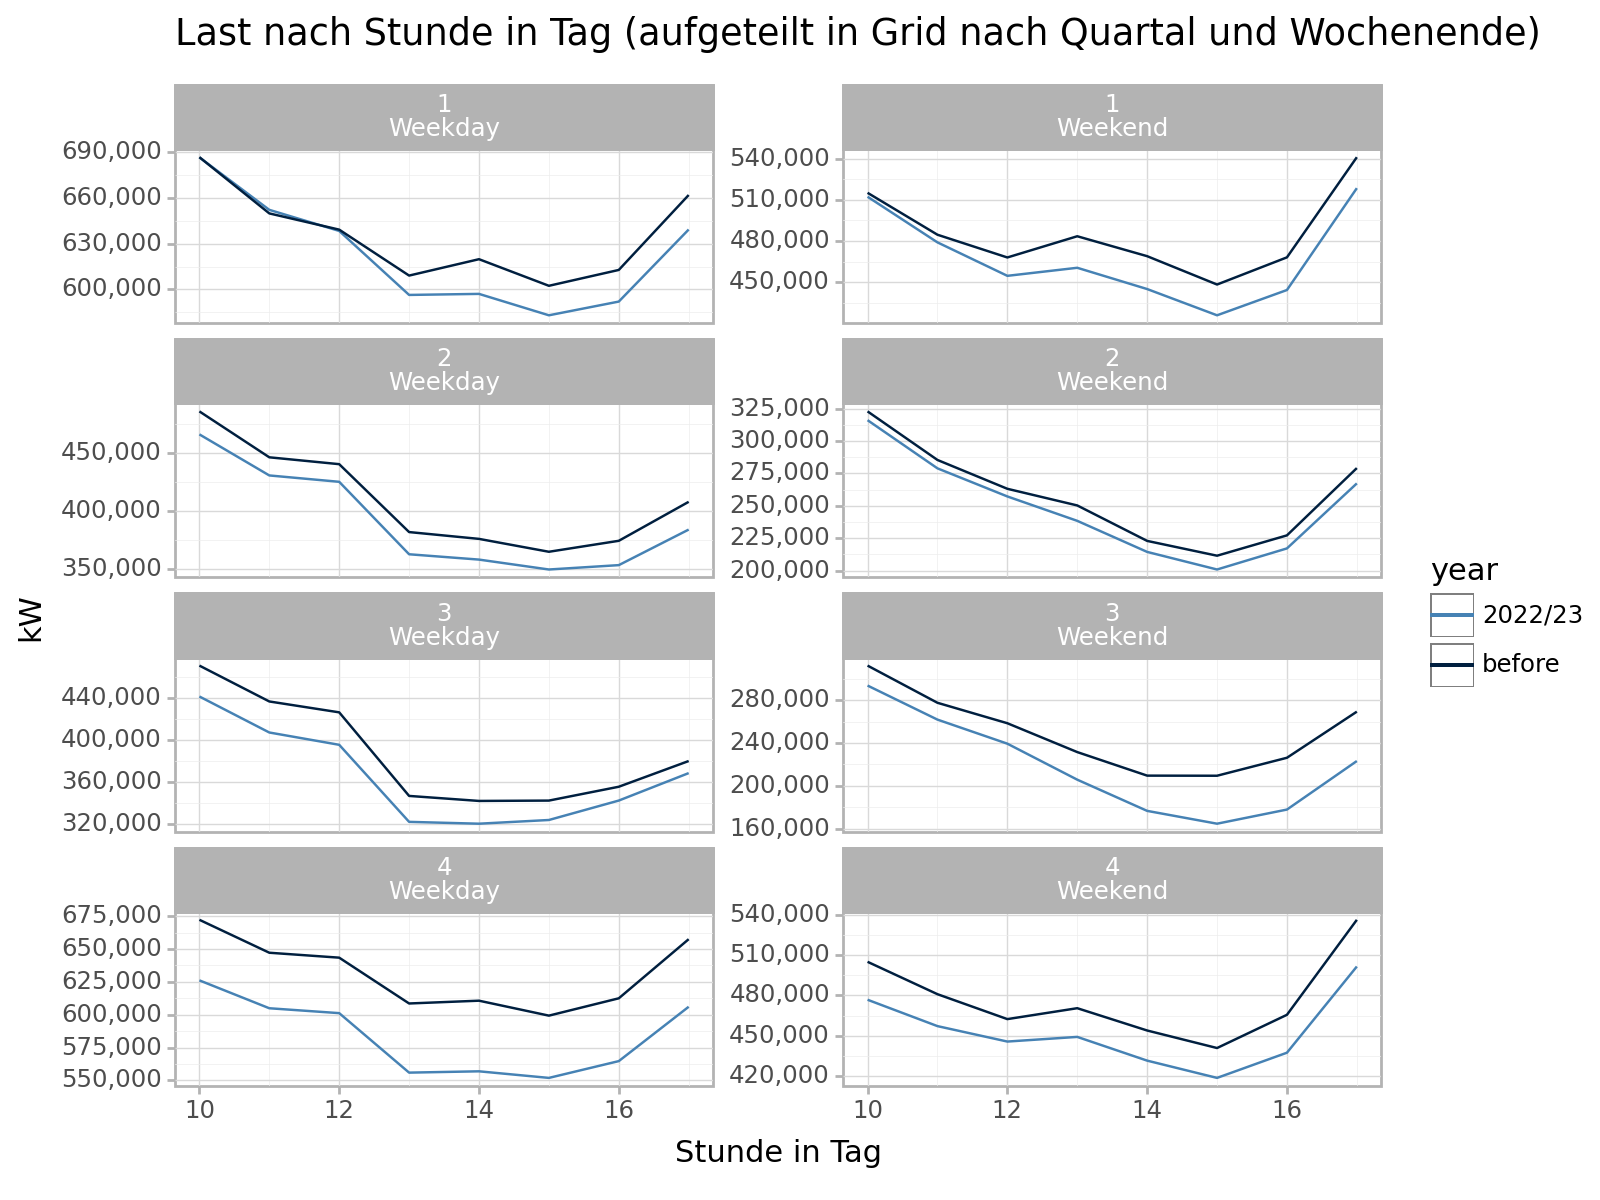

<Figure Size: (800 x 600)>

In [218]:
(
    ggplot(
        data=(
            pd.concat(
                [
                    pd.read_pickle("Preprocessed Data/df_base_preprocessed.pickle"),
                    pd.read_pickle(
                        "Preprocessed Data/df_base_preprocessed_holdout.pickle"
                    ),
                ],
                axis=0,
            )
            .reset_index(drop=True)
            .filter(["datetime", "kW"])
            .assign(
                month=lambda x: x.datetime.dt.quarter,
                year=lambda x: np.where(
                    np.isin(x.datetime.dt.year, [2022, 2023]), "2022/23", "before"
                ),
                hour=lambda x: x.datetime.dt.hour + 1,
                weekend=lambda x: np.where(
                    x.datetime.dt.weekday >= 5, "Weekend", "Weekday"
                ),
            )
            .query("hour > 9 and hour < 18")
            .groupby(["year", "month", "hour", "weekend"])
            .apply(
                lambda x: pd.Series(
                    {
                        "lower": x.kW.quantile(0.05),
                        "middle": x.kW.mean(),
                        "higher": x.kW.quantile(0.95),
                    }
                )
            )
            .reset_index()
        ),
        mapping=aes(x="hour"),
    )
    + labs(
        title="Last nach Stunde in Tag (aufgeteilt in Grid nach Quartal und Wochenende)",
        y="kW",
        x="Stunde in Tag",
    )
    + geom_line(mapping=aes(y="middle", colour="year", group="year"))
    + facet_wrap("~ month + weekend", scales="free_y", ncol=2)
    + scale_y_continuous(labels=comma_format())
    + scale_colour_manual(
        values=[
            "#4682b4",  # Medium Blue
            "#001f3f",  # Very Dark Blue
        ]
    )
    + theme_light()
    + theme(figure_size=[8, 6])
)

### Visualisations

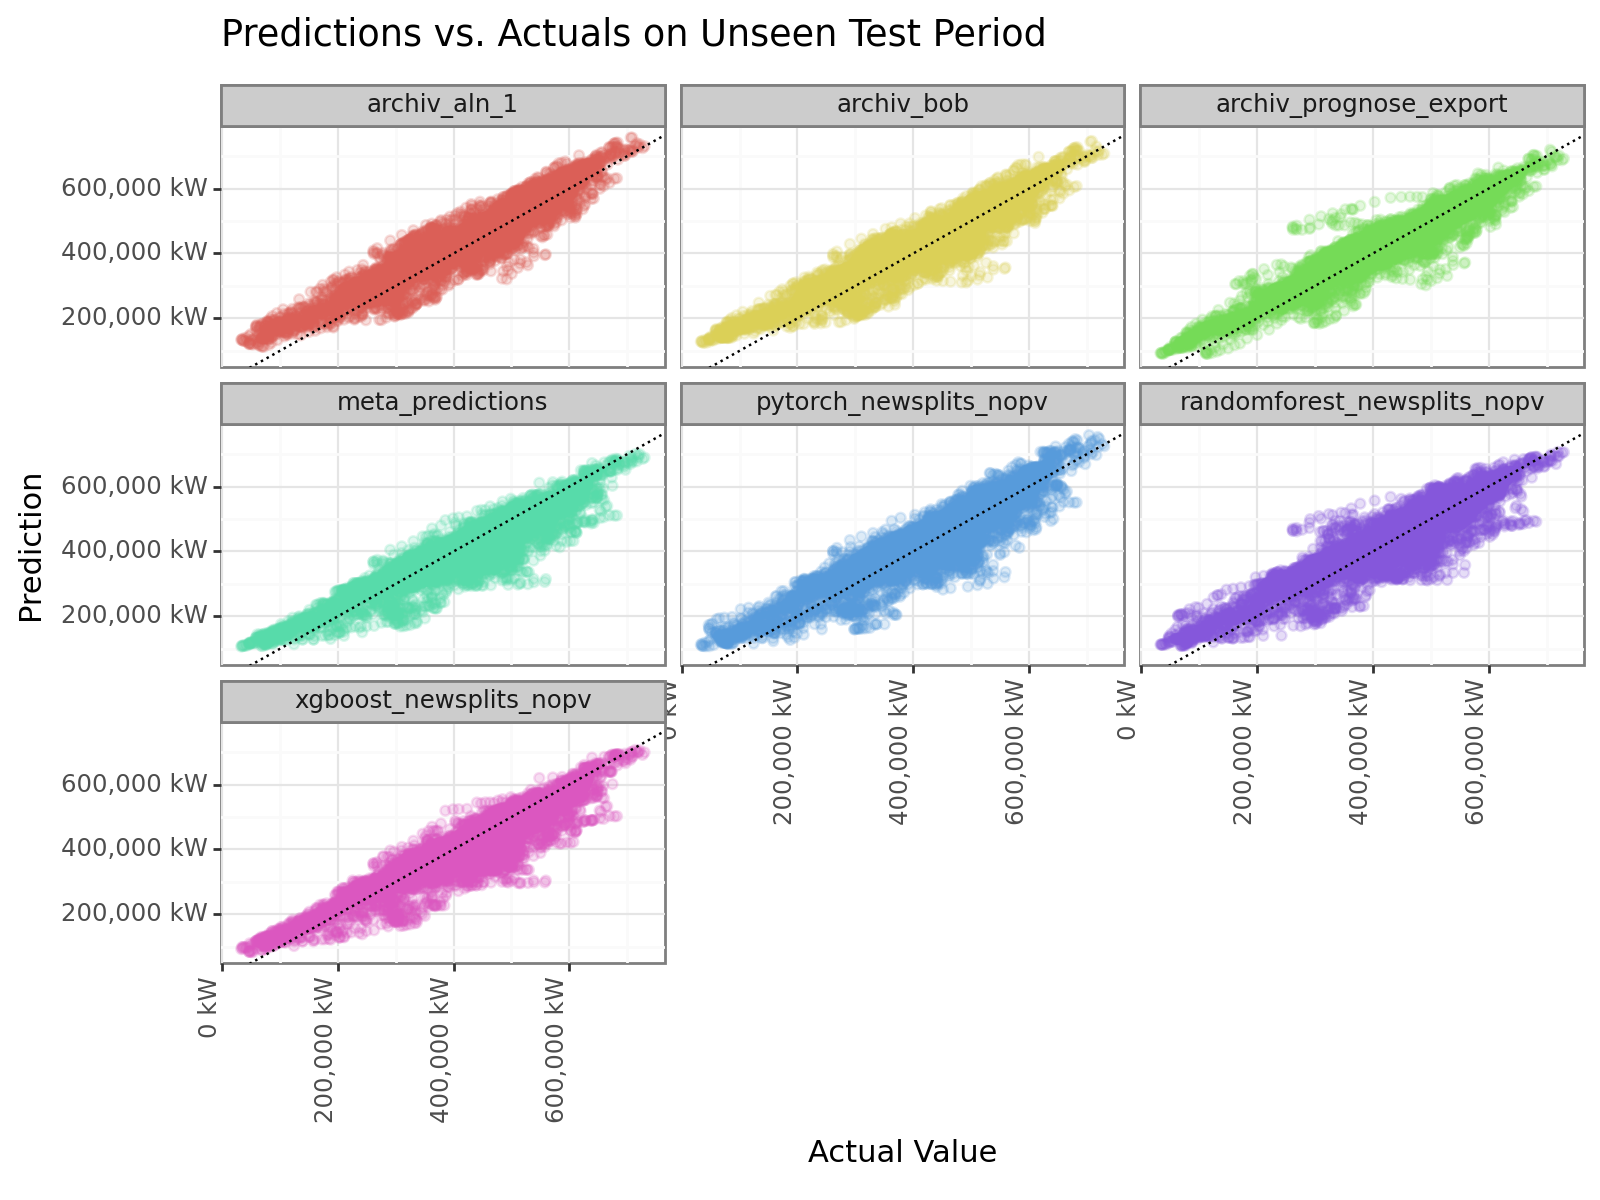

<Figure Size: (800 x 600)>

In [23]:
(
    ggplot(
        data=predictions.merge(bal_energy, how="left", on="datetime")
        .filter(
            [
                "meta_predictions",
                "actuals",
                "pytorch_newsplits_nopv",
                "xgboost_newsplits_nopv",
                "randomforest_newsplits_nopv",
                "archiv_aln_1",
                "archiv_bob",
                "archiv_prognose_export",
            ]
        )
        .melt(id_vars="actuals"),
        mapping=aes(x="actuals", y="value", colour="variable"),
    )
    + geom_point(alpha=0.2)
    + geom_abline(linetype="dotted", colour="black")
    + labs(
        title="Predictions vs. Actuals on Unseen Test Period",
        y="Prediction",
        x="Actual Value",
    )
    + facet_wrap("~ variable")
    + scale_y_continuous(
        labels=currency_format(prefix="", suffix=" kW", big_mark=",", digits=0)
    )
    + scale_x_continuous(
        labels=currency_format(prefix="", suffix=" kW", big_mark=",", digits=0)
    )
    + theme_bw()
    + theme(
        figure_size=[8, 6],
        axis_text_x=element_text(rotation=90, hjust=1),
        legend_position="none",
    )
)

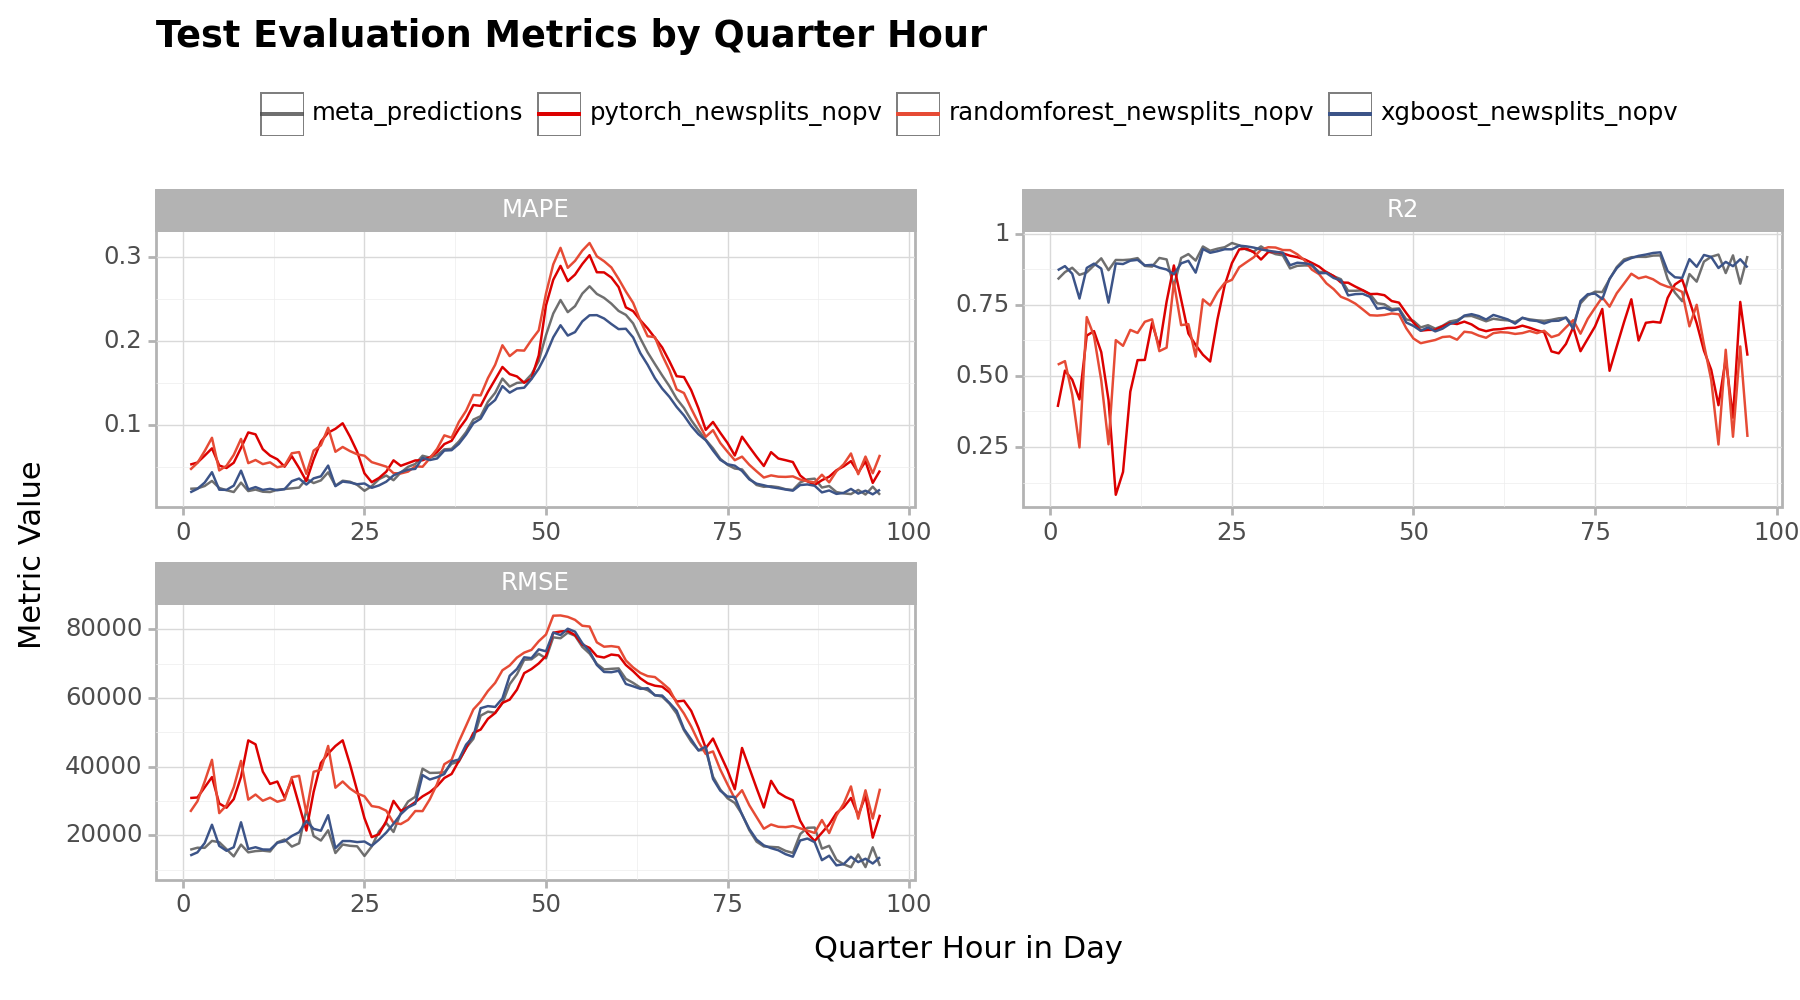

<Figure Size: (900 x 500)>

In [24]:
(
    ggplot(
        data=(
            predictions.assign(
                quarter_hour=lambda x: (x.datetime.dt.hour * 60 + x.datetime.dt.minute)
                // 15
                + 1
            )
            .drop("datetime", axis=1)
            .melt(
                id_vars=["quarter_hour", "actuals"], var_name="model", value_name="pred"
            )
            .groupby(["quarter_hour", "model"])
            .apply(
                lambda x: pd.Series(
                    {
                        "R2": r2_score(x["actuals"], x["pred"]),
                        "MAPE": mean_absolute_percentage_error(x["actuals"], x["pred"]),
                        "RMSE": mean_squared_error(x["actuals"], x["pred"], squared=False),
                        # "MedAE": median_absolute_error(x["actuals"], x["pred"]),

                    }
                )
            )
            .reset_index()
            .melt(
                id_vars=["quarter_hour", "model"],
                var_name="metric",
                value_name="metric_value",
            )
        ),
        mapping=aes(x="quarter_hour", y="metric_value", colour="model"),
    )
    + geom_line(alpha=0.8)
    # + geom_point(alpha=0.6)
    + labs(
        title="Test Evaluation Metrics by Quarter Hour",
        x="Quarter Hour in Day",
        y="Metric Value",
    )
    + facet_wrap("~ metric", scales="free", ncol=2)
    + scale_colour_manual(values=["#4B4B4B", "#DC0000FF", "#E64B35FF", "#3C5488FF", "dodgerblue"])
    + theme_light()
    + theme(
        figure_size=[9, 5],
        plot_title=element_text(face="bold"),
        legend_position="top",
        legend_title=element_blank(),
    )
)

The target is very differently distributed amongst the splits, which is due to the seasonal effect. It might be worth a try to have a full year in the validation period as opposed to just two months.

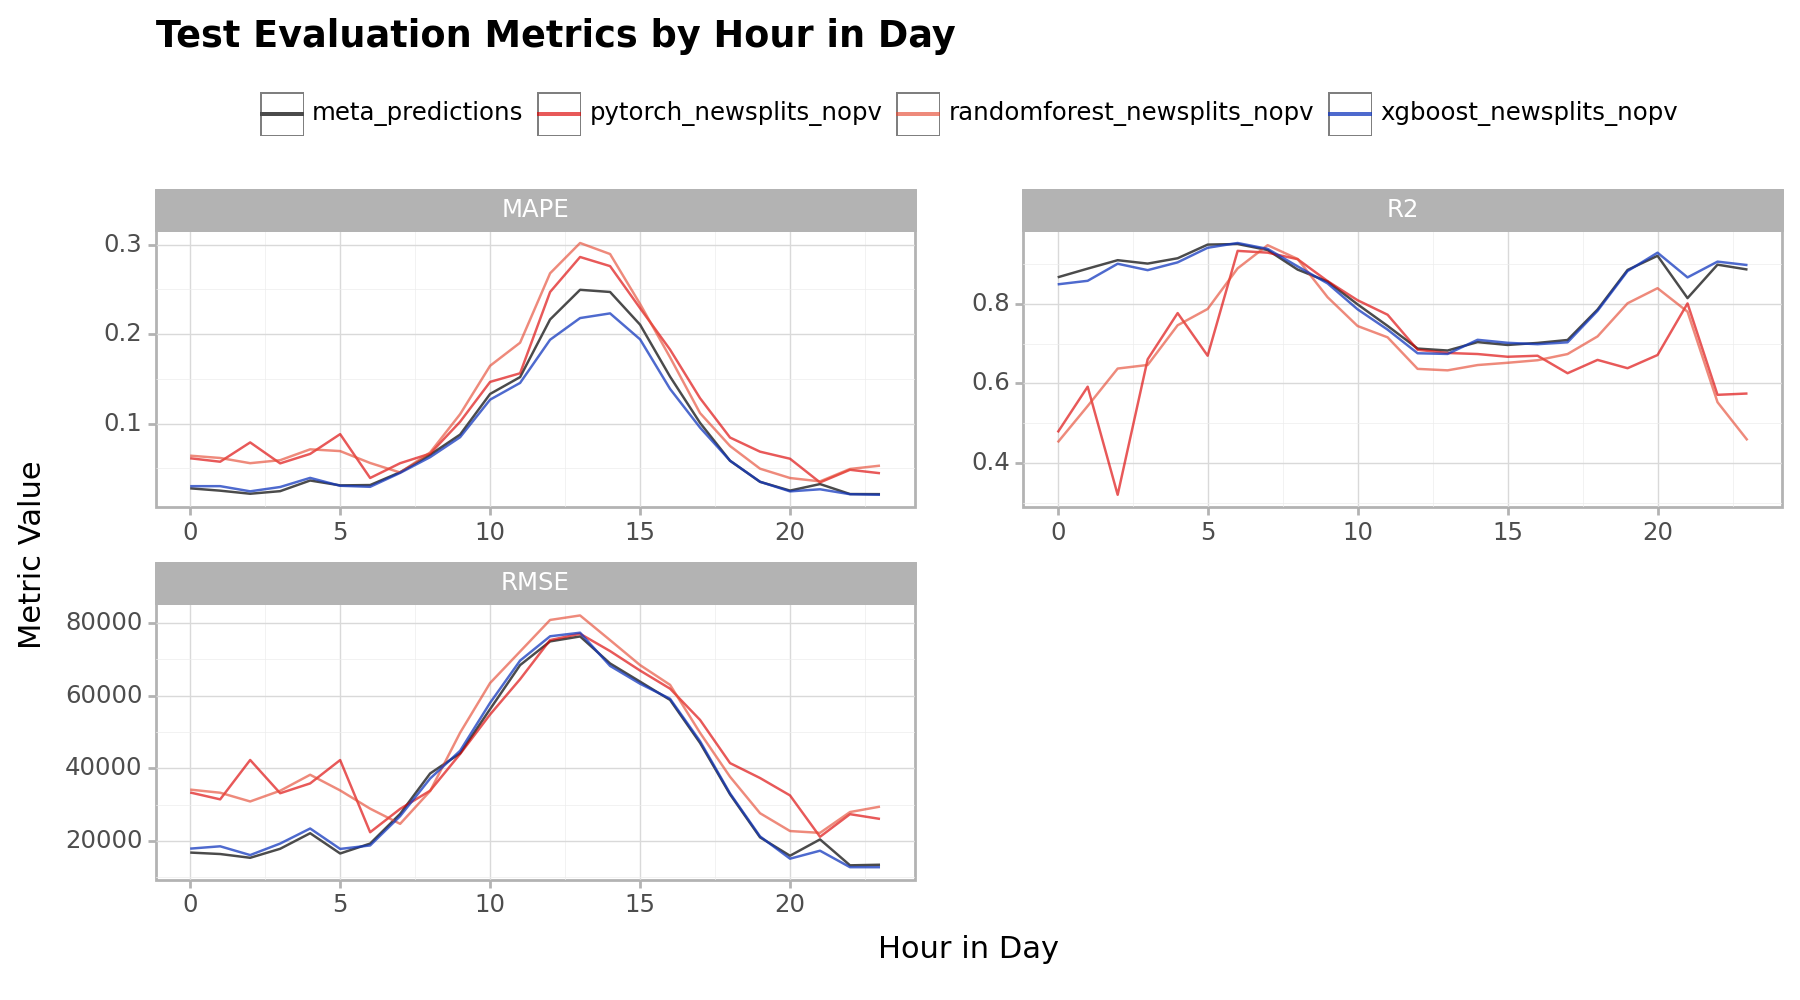

<Figure Size: (900 x 500)>

In [11]:
(
    ggplot(
        data=(
            predictions.assign(
                day_hour=lambda x: x.datetime.dt.hour
            )
            .drop("datetime", axis=1)
            .melt(
                id_vars=["day_hour", "actuals"], var_name="model", value_name="pred"
            )
            .groupby(["day_hour", "model"])
            .apply(
                lambda x: pd.Series(
                    {
                        "R2": r2_score(x["actuals"], x["pred"]),
                        "MAPE": mean_absolute_percentage_error(x["actuals"], x["pred"]),
                        "RMSE": mean_squared_error(x["actuals"], x["pred"], squared=False),
                    }
                )
            )
            .reset_index()
            .melt(
                id_vars=["day_hour", "model"],
                var_name="metric",
                value_name="metric_value",
            )
        ),
        mapping=aes(x="day_hour", y="metric_value", colour="model"),
    )
    + geom_line()
    + labs(
        title="Test Evaluation Metrics by Hour in Day",
        x="Hour in Day",
        y="Metric Value",
    )
    + facet_wrap("~ metric", scales="free", ncol=2)
    + scale_colour_manual(values=["#4B4B4BFF", "#DC0000A6", "#E64B35A6", "#1338BEBF", "#1E90FFA6"])
    + theme_light()
    + theme(
        figure_size=[9, 5],
        plot_title=element_text(face="bold"),
        legend_position="top",
        legend_title=element_blank(),
    )
)

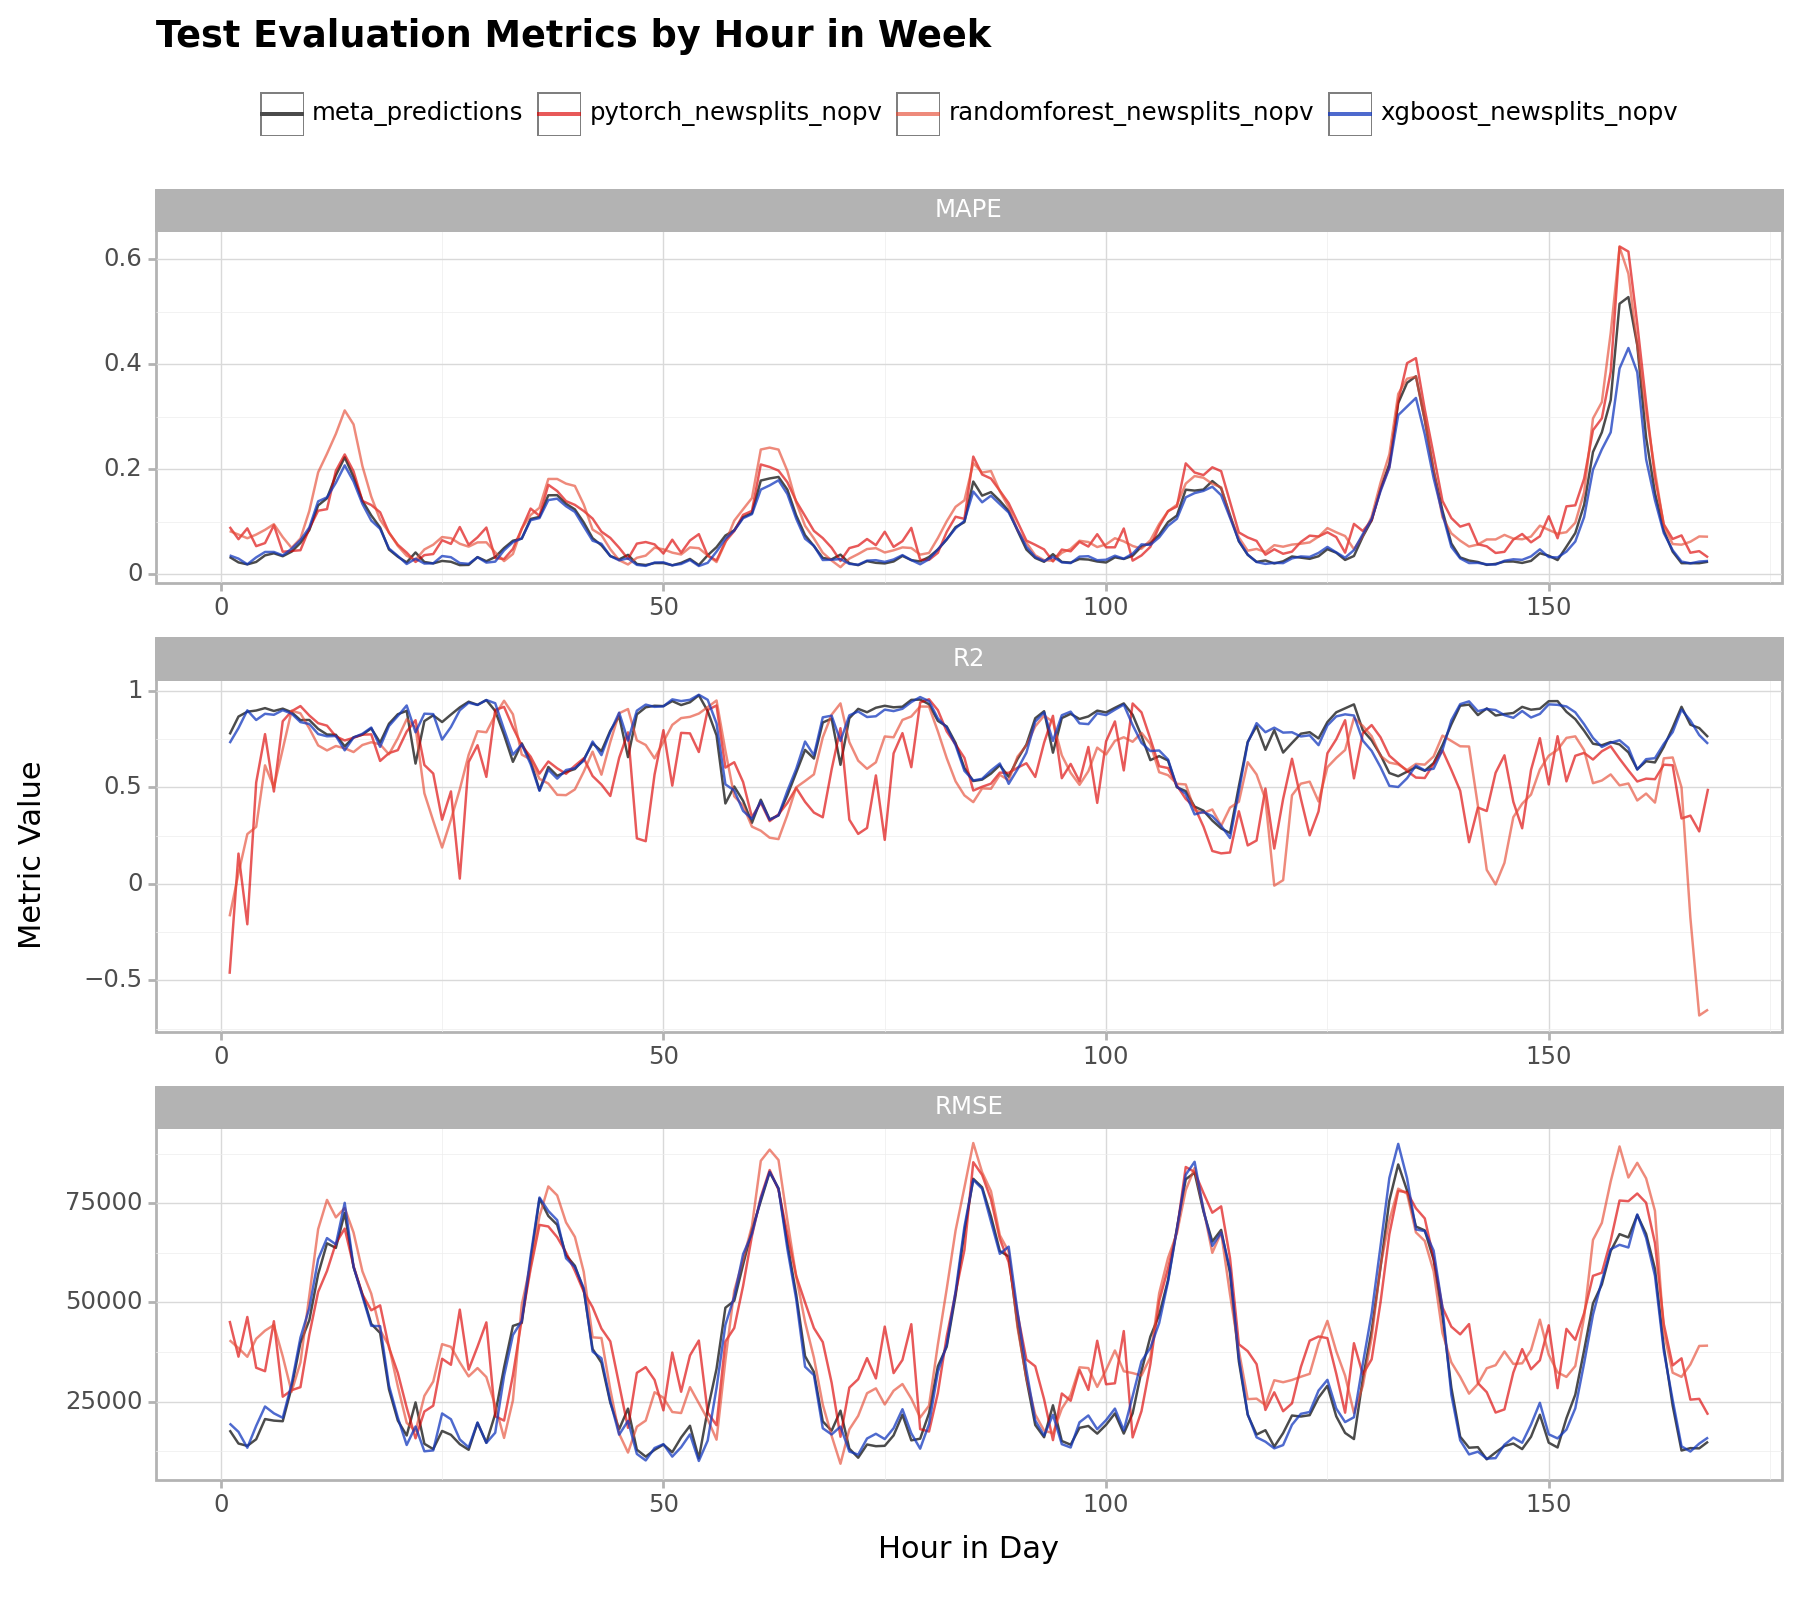

<Figure Size: (900 x 800)>

In [12]:
(
    ggplot(
        data=(
            predictions.assign(
                week_hour=lambda x: x.datetime.dt.dayofweek * 24 + (x.datetime.dt.hour + 1)
            )
            .drop("datetime", axis=1)
            .melt(
                id_vars=["week_hour", "actuals"], var_name="model", value_name="pred"
            )
            .groupby(["week_hour", "model"])
            .apply(
                lambda x: pd.Series(
                    {
                        "R2": r2_score(x["actuals"], x["pred"]),
                        "MAPE": mean_absolute_percentage_error(x["actuals"], x["pred"]),
                        "RMSE": mean_squared_error(x["actuals"], x["pred"], squared=False),
                    }
                )
            )
            .reset_index()
            .melt(
                id_vars=["week_hour", "model"],
                var_name="metric",
                value_name="metric_value",
            )
        ),
        mapping=aes(x="week_hour", y="metric_value", colour="model"),
    )
    + geom_line()
    + labs(
        title="Test Evaluation Metrics by Hour in Week",
        x="Hour in Day",
        y="Metric Value",
    )
    + facet_wrap("~ metric", scales="free", ncol=1)
    + scale_colour_manual(values=["#4B4B4BFF", "#DC0000A6", "#E64B35A6", "#1338BEBF", "#1E90FFA6"])
    + theme_light()
    + theme(
        figure_size=[9, 8],
        plot_title=element_text(face="bold"),
        legend_position="top",
        legend_title=element_blank(),
    )
)

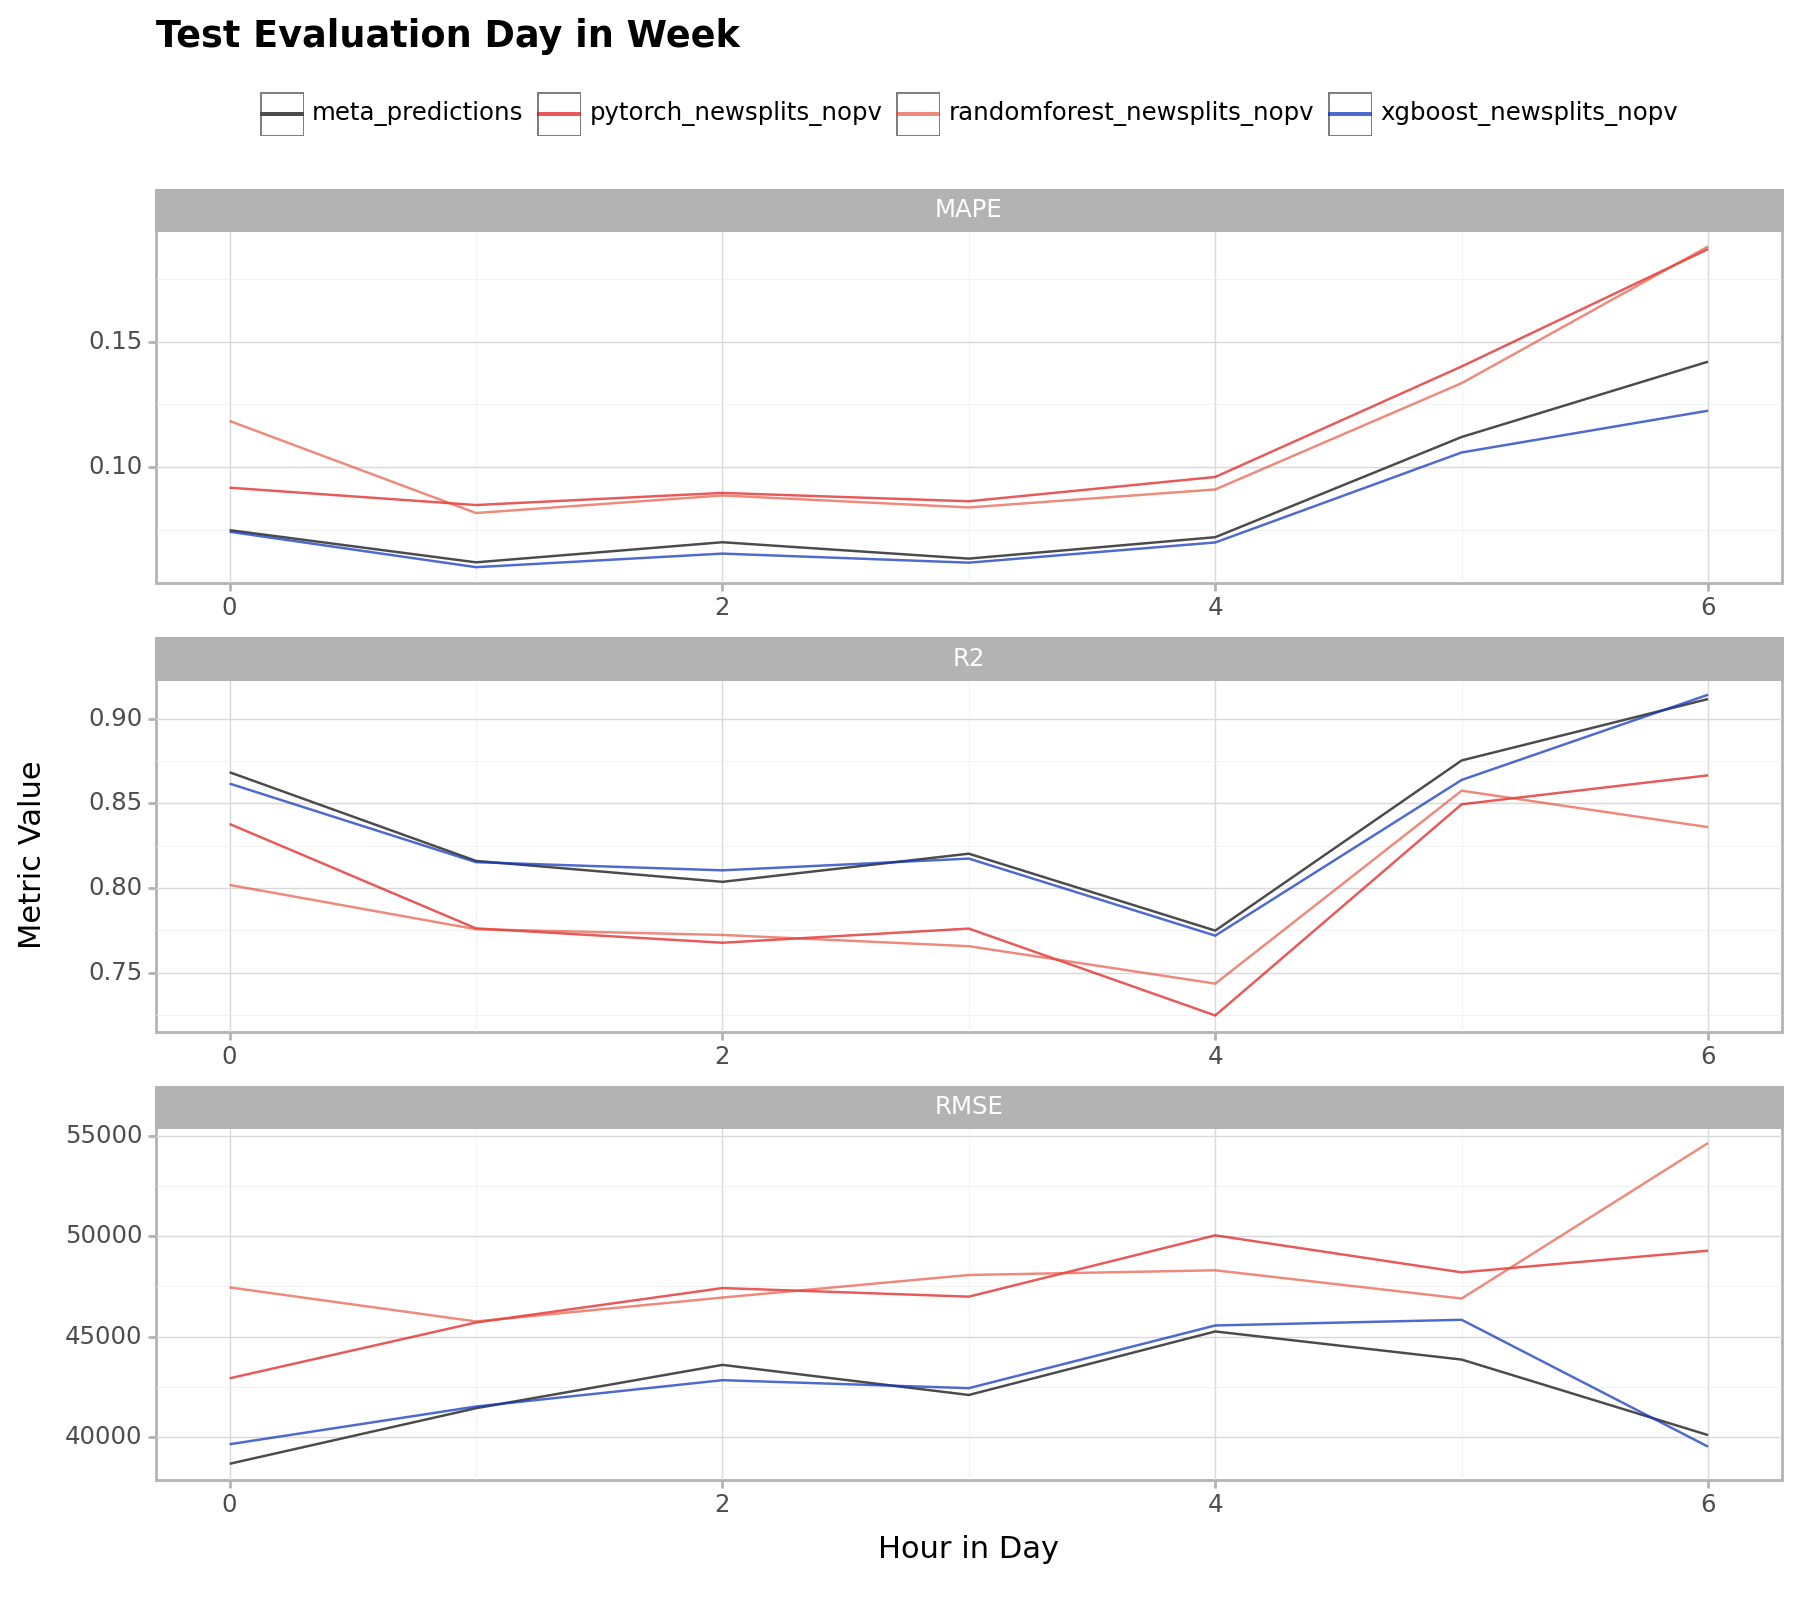

<Figure Size: (900 x 800)>

In [13]:
(
    ggplot(
        data=(
            predictions.assign(
                day_in_week=lambda x: x.datetime.dt.dayofweek
            )
            .drop("datetime", axis=1)
            .melt(
                id_vars=["day_in_week", "actuals"], var_name="model", value_name="pred"
            )
            .groupby(["day_in_week", "model"])
            .apply(
                lambda x: pd.Series(
                    {
                        "R2": r2_score(x["actuals"], x["pred"]),
                        "MAPE": mean_absolute_percentage_error(x["actuals"], x["pred"]),
                        "RMSE": mean_squared_error(x["actuals"], x["pred"], squared=False),
                    }
                )
            )
            .reset_index()
            .melt(
                id_vars=["day_in_week", "model"],
                var_name="metric",
                value_name="metric_value",
            )
        ),
        mapping=aes(x="day_in_week", y="metric_value", colour="model"),
    )
    + geom_line()
    + labs(
        title="Test Evaluation Day in Week",
        x="Hour in Day",
        y="Metric Value",
    )
    + facet_wrap("~ metric", scales="free", ncol=1)
    + scale_colour_manual(values=["#4B4B4BFF", "#DC0000A6", "#E64B35A6", "#1338BEBF", "#1E90FFA6"])
    + theme_light()
    + theme(
        figure_size=[9, 8],
        plot_title=element_text(face="bold"),
        legend_position="top",
        legend_title=element_blank(),
    )
)